<a href="https://colab.research.google.com/github/Popseli/Nature-Inspired-Hyperparameter-Optimization/blob/main/Final_Stacking_Ensemble_GASearchCV_Grega_Large_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GASearchCV for Feature Selection & Tuning, outliers inclusive, balanced data (undersampling)

## 1. Importing Libraries

In [59]:
# uploading the dataset file into the drive
# from google.colab import files
# uploaded = files.upload()

In [60]:
import pandas as pd
df = pd.read_csv('dataset_large.csv')

In [61]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar 13 12:45:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              26W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [62]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import time
#import category_encoders as ce
from sklearn.utils import shuffle
import missingno as msno
from sklearn.feature_selection import VarianceThreshold
#from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from imblearn.under_sampling import RandomUnderSampler
#from pycm import *   # a multi-class confusion matrix library
from sklearn.preprocessing import LabelEncoder, StandardScaler
#from sklearn.feature_selection import RFE
#from genetic_selection import GeneticSelectionCV    # from sklearn-genetic package
!pip install sklearn-genetic-opt
from sklearn_genetic import GAFeatureSelectionCV, GASearchCV # from sklearn-genetic opt package
#from sklearn_genetic import GeneticSearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold  # a CV with folds where each one contains the same ratio of classes as in general dataset
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.neural_network import MLPClassifier
#from sklearn.experimental import enable_hist_gradient_boosting
#from skope_rules import LMTClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier,AdaBoostClassifier,BaggingClassifier,HistGradientBoostingClassifier,IsolationForest
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
#from imblearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score,confusion_matrix,make_scorer,precision_score,recall_score,f1_score,roc_auc_score,roc_curve,auc,precision_recall_curve
!pip install shap
import shap
import itertools
import warnings

In [64]:
time_start = time.time()

In [65]:
# disable warnings
warnings.filterwarnings("ignore")

# set plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # improves resolutions of inline plots
rcParams['axes.titlepad'] = 11    # set a distance between title and plot
#rcParams['figure.figsize'] = 12,6
rcParams['font.size'] = 9
rcParams["legend.fontsize"] = 8
rcParams["xtick.labelsize"] = 8
rcParams["ytick.labelsize"] = 8

# display options
pd.options.display.max_columns = 150

# define constant variable for a seed
RANDOM_STATE = 2

# expand width of notebook cells for wider viewing
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
#display(HTML("<style>.prompt { display:none !important; }</style>"))

In [66]:
# # get data
# file = 'dataset_large.csv'
# df = pd.read_csv(file)

## 2. Data Profiling

In [67]:
df.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain,qty_dot_directory,qty_hyphen_directory,qty_underline_directory,qty_slash_directory,qty_questionmark_directory,qty_equal_directory,qty_at_directory,qty_and_directory,qty_exclamation_directory,qty_space_directory,qty_tilde_directory,qty_comma_directory,qty_plus_directory,qty_asterisk_directory,qty_hashtag_directory,qty_dollar_directory,qty_percent_directory,directory_length,qty_dot_file,qty_hyphen_file,qty_underline_file,qty_slash_file,qty_questionmark_file,qty_equal_file,qty_at_file,qty_and_file,qty_exclamation_file,qty_space_file,qty_tilde_file,qty_comma_file,qty_plus_file,qty_asterisk_file,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,25,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,17,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.207316,0,60781,-1,-1,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,0,0,0,0,0,0,0,3,223,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,16,0,0,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,42,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,1,0,0,3,0,2,0,0,0,0,0,0,0,0,0,165,0,3,0,0.499566,-1,36024,579,150,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,15,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,14,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.935901,0,4766,-1,-1,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,81,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,19,0,0,2,0,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,62,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.410021,0,20454,-1,-1,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,19,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,19,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.410761,0,53831,6998,306,1,2,1,3597,0,1,0,0,0,0


In [68]:
df.shape

(88647, 112)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88647 entries, 0 to 88646
Columns: 112 entries, qty_dot_url to phishing
dtypes: float64(1), int64(111)
memory usage: 75.7 MB


All columns are numerical, no categorical columns

In [70]:
# display statistical measures of all numerical features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
qty_dot_url,88647.0,2.191343,1.235636,1.0,2.0,2.0,2.0,24.0
qty_hyphen_url,88647.0,0.328810,1.119286,0.0,0.0,0.0,0.0,35.0
qty_underline_url,88647.0,0.113879,0.657767,0.0,0.0,0.0,0.0,21.0
qty_slash_url,88647.0,1.281781,1.893929,0.0,0.0,0.0,2.0,44.0
qty_questionmark_url,88647.0,0.009329,0.112568,0.0,0.0,0.0,0.0,9.0
...,...,...,...,...,...,...,...,...
qty_redirects,88647.0,0.343903,0.783892,-1.0,0.0,0.0,1.0,17.0
url_google_index,88647.0,0.001410,0.058640,-1.0,0.0,0.0,0.0,1.0
domain_google_index,88647.0,0.002019,0.063250,-1.0,0.0,0.0,0.0,1.0
url_shortened,88647.0,0.005482,0.073841,0.0,0.0,0.0,0.0,1.0


In [71]:
# renaming 'phishing' column to 'class'
df.rename(columns={'phishing': 'class'}, inplace=True)

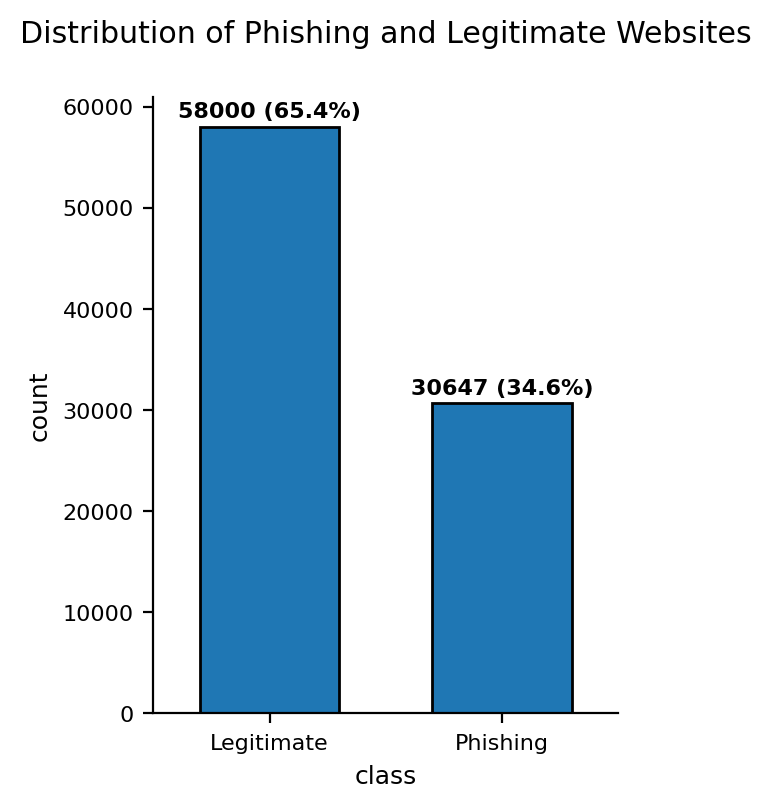

In [72]:
## checking distribution of samples per class. It can be observed that the binary classes are nearly balanced.
fig, ax = plt.subplots(figsize=(3, 4))
ax = sns.countplot(data=df, x='class', saturation=1.0, edgecolor='black', width=0.6)
# display counts of websites on top of bars
abs_values = df['class'].value_counts(ascending=False)
rel_values = df['class'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.1f}%)' for p in zip(abs_values, rel_values)]
#ax.bar_label(container=ax.containers[0], labels=lbls, fontsize=8, padding=2)
ax.bar_label(container=ax.containers[0], labels=lbls, fontsize=8, fontweight='bold', padding=2)
plt.title('Distribution of Phishing and Legitimate Websites', y=1.04)
# renaming xticks labels from 0 and 1 to legitimate and phishing respectively
x_labels = ['Legitimate', 'Phishing']
ax.set_xticklabels(x_labels)
#ax.spines[['right', 'top']].set_visible(False) # remove right and top spines
sns.despine(fig=None, ax=ax, top=True, right=True, left=False, bottom=False, offset=None, trim=False)  # remove right and top spines
plt.savefig('Dataset Distribution.png', dpi=150)
plt.show()

## 3. Data Cleaning, Exploration and Pre-processing

#### 3.1 Handling Negative Values

In [73]:
# count columns with negative values
(df < 0).any(axis=0).sum()

66

In [74]:
# count rows with negative values
(df < 0).any(axis=1).sum()

85084

In [75]:
# count all negative values in the df
#(df < 0).sum().sum()
df.where(df < 0).count().sum()

3428432

In [76]:
# identify records with negative values in any of the columns
df_neg = df.loc[:,(df < 0).any()]
df_neg.head()

,qty_dot_directory,qty_hyphen_directory,qty_underline_directory,qty_slash_directory,qty_questionmark_directory,qty_equal_directory,qty_at_directory,qty_and_directory,qty_exclamation_directory,qty_space_directory,qty_tilde_directory,qty_comma_directory,qty_plus_directory,qty_asterisk_directory,qty_hashtag_directory,qty_dollar_directory,qty_percent_directory,directory_length,qty_dot_file,qty_hyphen_file,qty_underline_file,qty_slash_file,qty_questionmark_file,qty_equal_file,qty_at_file,qty_and_file,qty_exclamation_file,qty_space_file,qty_tilde_file,qty_comma_file,qty_plus_file,qty_asterisk_file,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,ttl_hostname,qty_redirects,url_google_index,domain_google_index
0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.207316,0,60781,-1,-1,1,892,0,0,0
1,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,42,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,1,0,0,3,0,2,0,0,0,0,0,0,0,0,0,165,0,3,0.499566,-1,36024,579,150,1,9540,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.935901,0,4766,-1,-1,1,589,0,0,0
3,2,0,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,62,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.410021,0,20454,-1,-1,1,292,0,0,0
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.410761,0,53831,6998,306,1,3597,1,0,0


In [77]:
# list columns with negative values
neg_cols = df_neg.columns.to_list()
print(neg_cols)

['qty_dot_directory', 'qty_hyphen_directory', 'qty_underline_directory', 'qty_slash_directory', 'qty_questionmark_directory', 'qty_equal_directory', 'qty_at_directory', 'qty_and_directory', 'qty_exclamation_directory', 'qty_space_directory', 'qty_tilde_directory', 'qty_comma_directory', 'qty_plus_directory', 'qty_asterisk_directory', 'qty_hashtag_directory', 'qty_dollar_directory', 'qty_percent_directory', 'directory_length', 'qty_dot_file', 'qty_hyphen_file', 'qty_underline_file', 'qty_slash_file', 'qty_questionmark_file', 'qty_equal_file', 'qty_at_file', 'qty_and_file', 'qty_exclamation_file', 'qty_space_file', 'qty_tilde_file', 'qty_comma_file', 'qty_plus_file', 'qty_asterisk_file', 'qty_hashtag_file', 'qty_dollar_file', 'qty_percent_file', 'file_length', 'qty_dot_params', 'qty_hyphen_params', 'qty_underline_params', 'qty_slash_params', 'qty_questionmark_params', 'qty_equal_params', 'qty_at_params', 'qty_and_params', 'qty_exclamation_params', 'qty_space_params', 'qty_tilde_params', 

In [78]:
# determine total number of negatives values in each column
df_neg_count = pd.DataFrame(np.sum(df[neg_cols] < 0)).reset_index()
df_neg_count.rename(columns={'index': 'Column', 0: 'Count'}, inplace=True)
df_neg_count.sort_values(by='Count', ascending=False, inplace=True)
df_neg_count.head(3)

,Column,Count
48,qty_plus_params,81225
49,qty_asterisk_params,81225
50,qty_hashtag_params,81225


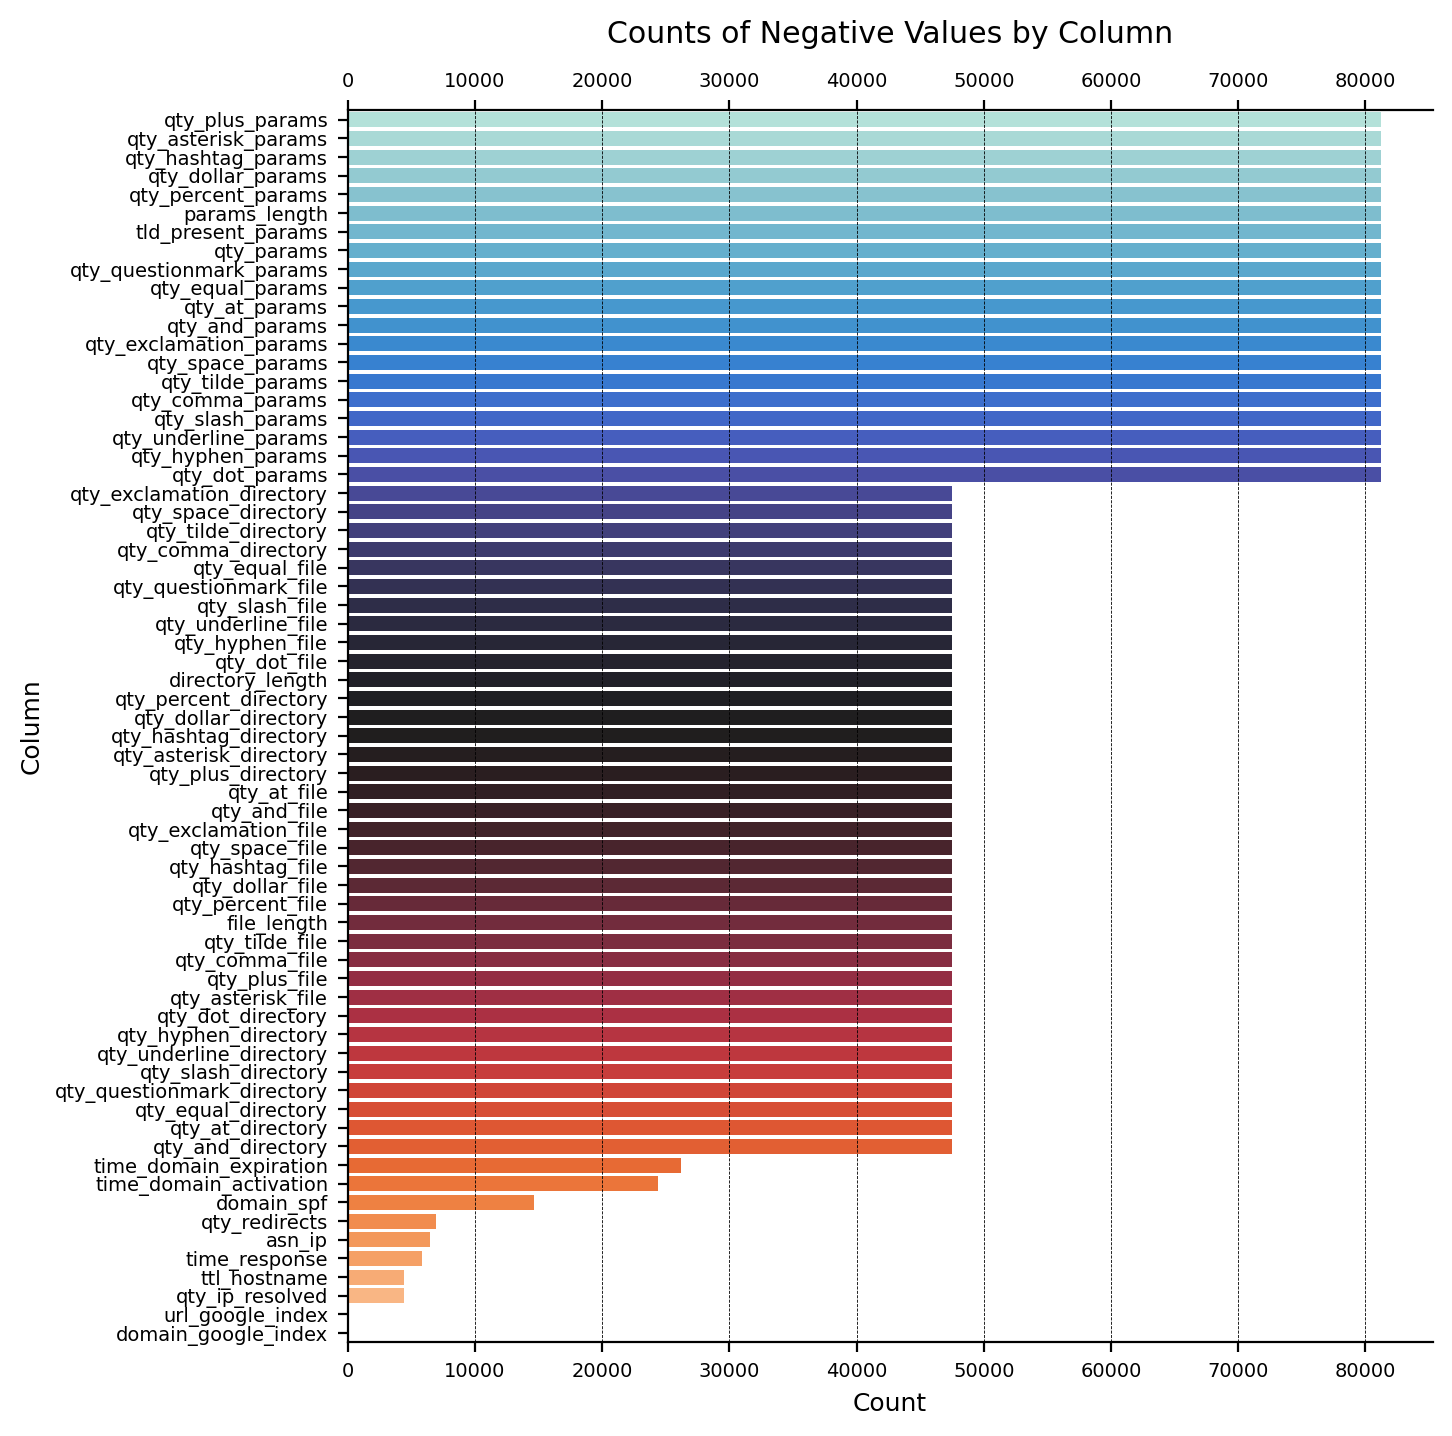

In [79]:
# plot counts of negative values by columns
fig, ax = plt.subplots(figsize=(7, 8))
ax = sns.barplot(data=df_neg_count, x='Count', y='Column', palette='icefire', saturation=1.0)
plt.title('Counts of Negative Values by Column', y=1.03)
ax.tick_params(right=False, top=True, labelright=False, labeltop=True, labelrotation=0)  # display control of x and y ticks at the top and right sides of the plot
plt.grid(axis='x', linestyle='--', linewidth=0.3, color='black')
ax.spines[['right']].set_visible(False) # remove the right spine
plt.yticks(fontsize=7)
plt.xticks(fontsize=7)
plt.show()

In [80]:
# replacing negative values with null
df[df < 0] = np.nan

In [81]:
# check if all negative values have been replaced
df.where(df < 0).count().sum()

0

#### 3.2 Handling Missing Values

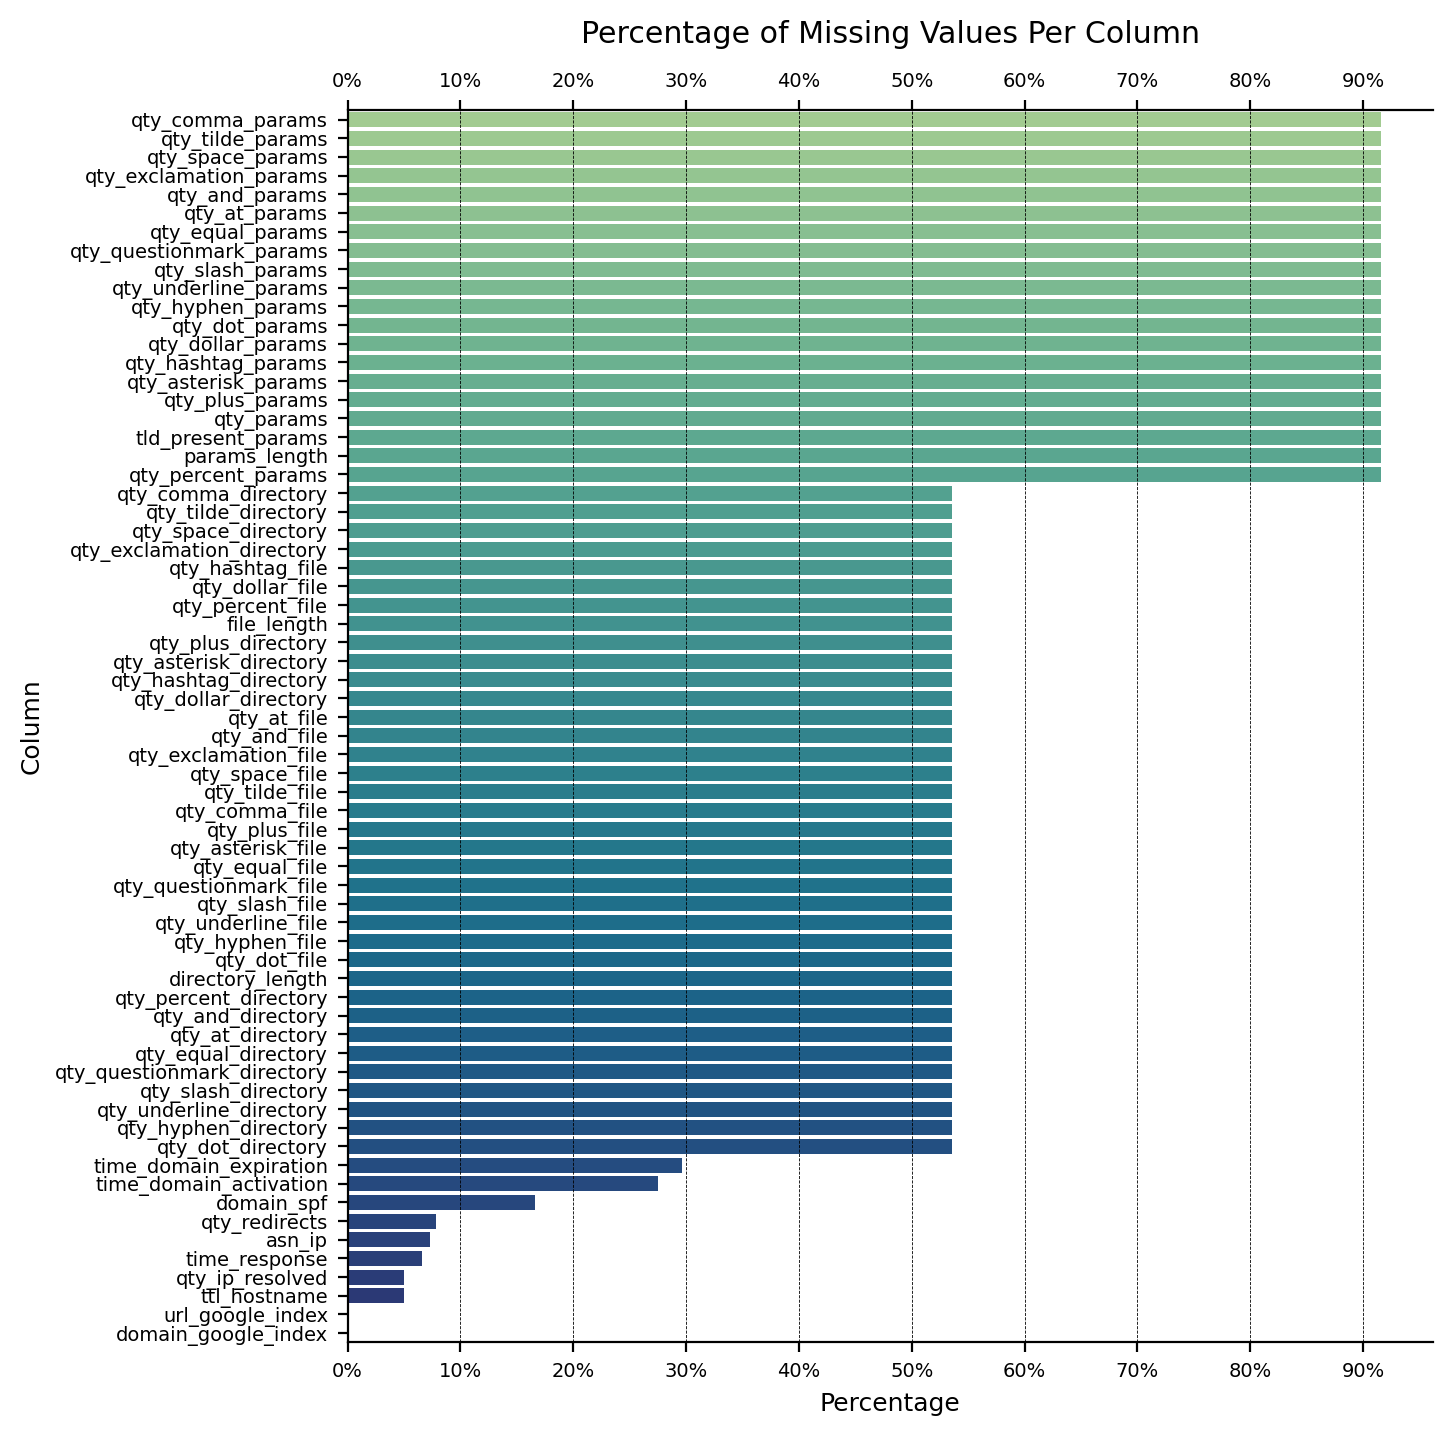

In [82]:
# Plot percentages of missing values for columns with at least one missing value
    # creating a dtaframe of missing values
null_cols = round((df.isnull().sum()/df.shape[0]*100), 1).sort_values(ascending=False)
null_cols = null_cols[null_cols > 0.0]
df_null_cols = pd.DataFrame(null_cols).reset_index()
df_null_cols.rename(columns={'index': 'Column', 0: 'Percentage'}, inplace=True)
df_null_cols.sort_values(by='Percentage', ascending=False, inplace=True)

    # plot the dataframe
fig, ax = plt.subplots(figsize=(7, 8))
ax = sns.barplot(data=df_null_cols, x='Percentage', y='Column', palette='crest', saturation=1.0)
plt.title('Percentage of Missing Values Per Column', y=1.03)
ax.set(xticks=np.arange(0, 100, 10))  # adjust display frequency of xticks (start, max, interval)
ax.xaxis.set_major_formatter('{x:1.0f}%')  # add '%' to the existing numbers of xticks
ax.tick_params(right=False, top=True, labelright=False, labeltop=True, labelrotation=0)  # display control of x and y ticks at the top and right sides of the plot
plt.grid(axis='x', linestyle='--', linewidth=0.3, color='black')
ax.spines[['right']].set_visible(False) # remove the right spine
plt.yticks(fontsize=7)
plt.xticks(fontsize=7)
plt.show()

In [83]:
df_null_cols.head()

,Column,Percentage
15,qty_comma_params,91.6
14,qty_tilde_params,91.6
13,qty_space_params,91.6
12,qty_exclamation_params,91.6
11,qty_and_params,91.6


In [84]:
# dropping all columns with at least 50% missing values
df_null_cols_del = df_null_cols[df_null_cols['Percentage'] > 50.0]
cols_del = df_null_cols_del.Column.to_list()   # return a list of columns to be deleted
df.drop(cols_del, axis = 1, inplace = True)
print('Number of Dropped Columns: ', len(cols_del))

Number of Dropped Columns:  56


In [85]:
df.shape

(88647, 56)

In [86]:
# count number of missing values for each row in percentage
df['Percentage_NaNs'] = round((df.isnull().sum(axis=1) / len(df.columns.to_list())) * 100, 1)

In [87]:
# determine rows with missing values (in percentage)
df_row_nulls = df.loc[df['Percentage_NaNs'] > 0]
# count number of rows with missing values
len(df_row_nulls)

43874

In [88]:
# display rows with the highest missing values (in percentage)
df_row_nulls['Percentage_NaNs'].sort_values(ascending=False).head()

27634    16.1
40651    16.1
86060    16.1
15330    16.1
39572    16.1
Name: Percentage_NaNs, dtype: float64

In [89]:
# # determine and plot percentage of missing values for each row
#     # determine percentage of missing values for each row
# df_row_null_count = df_row_nulls['Percentage_NaNs'].value_counts().sort_values(ascending=False).to_frame().reset_index()
# df_row_null_count.rename(columns={'count': 'Count'}, inplace=True)
# df_row_null_count.sort_values('Percentage_NaNs', ascending=False, inplace=True)

#     # plot the dataframe
# fig, ax = plt.subplots(figsize=(3.5,4))
# ax = sns.barplot(data=df_row_null_count, x='Percentage_NaNs', y='Count', palette='crest', saturation=1.0)
# plt.title('Counts of Percentages of Missing Values Per Row', y=1.03)
# plt.yticks(fontsize=8)
# plt.xticks(fontsize=8, rotation=45)
# plt.show()

All rows have less than 17% of null values, with majority having less than 3.6%. This is within an acceptable range. Given that the total number of rows with missing values is almost half of the entire dataset, , we will not delete any row

In [90]:
# drop 'percentage_NaNs' column
df.drop('Percentage_NaNs', axis=1, inplace=True)

In [91]:
cols = df.columns.to_list()

In [92]:
# # imputing missing values
# imputer = SimpleImputer(missing_values=np.nan, strategy='median')
# df_np_array = imputer.fit_transform(df)
# df = pd.DataFrame(df_np_array, columns=[cols])
# df.head()

In [93]:
# imputing missing values
df = df.fillna(df.median())  # replace null values in each column with a median value of the same column

In [94]:
# confirming the imputation of null values
df.isnull().sum().sum()

0

#### 3.3 Handling Duplicates

In [95]:
# removing duplicates
original_rows = df.shape[0]
df.drop_duplicates(keep='first', inplace=True)
new_rows = df.shape[0]
print('Deleted number of duplicated rows: ', original_rows - new_rows)

Deleted number of duplicated rows:  1448


#### 3.4 Handling Low Variance Columns

Low (near zero) variance refers to a column with one or very few unique values

In [96]:
# determine and remove near zero variance columns
var_thr = VarianceThreshold(threshold = 0.05) # the threshold picks all columns consisting of at least 95% of the same value. This requires all columns to be in a numerical format. If categorical, they have to be converted before applying this method
df_X = df.drop('class', axis=1)
var_thr.fit(df_X)
columns_keep = df_X.columns[var_thr.get_support()]
print('Number of columns to keep:', len(columns_keep))

Number of columns to keep: 26


In [97]:
zero_var_cols = [column for column in df_X.columns if column not in columns_keep]
print('Number of columns with near zero variance:', len(zero_var_cols))
#print()
#print(zero_var_cols)

Number of columns with near zero variance: 29


In [98]:
df_X[zero_var_cols].nunique().sort_values(ascending=True)

qty_and_domain              1
qty_equal_domain            1
qty_exclamation_domain      1
qty_space_domain            1
qty_questionmark_domain     1
qty_slash_domain            1
qty_comma_domain            1
qty_tilde_domain            1
qty_asterisk_domain         1
qty_percent_domain          1
qty_dollar_domain           1
qty_hashtag_domain          1
qty_plus_domain             1
domain_in_ip                2
qty_at_domain               2
server_client_domain        2
url_shortened               2
email_in_url                2
url_google_index            2
domain_google_index         2
qty_underline_domain        4
qty_tilde_url               6
qty_questionmark_url        6
qty_hashtag_url             7
qty_space_url               8
qty_comma_url               8
qty_dollar_url             10
qty_exclamation_url        10
qty_plus_url               10
dtype: int64

In [99]:
df.drop(zero_var_cols, axis=1, inplace=True)
df.shape

(87199, 27)

#### 3.5 Handling Outliers

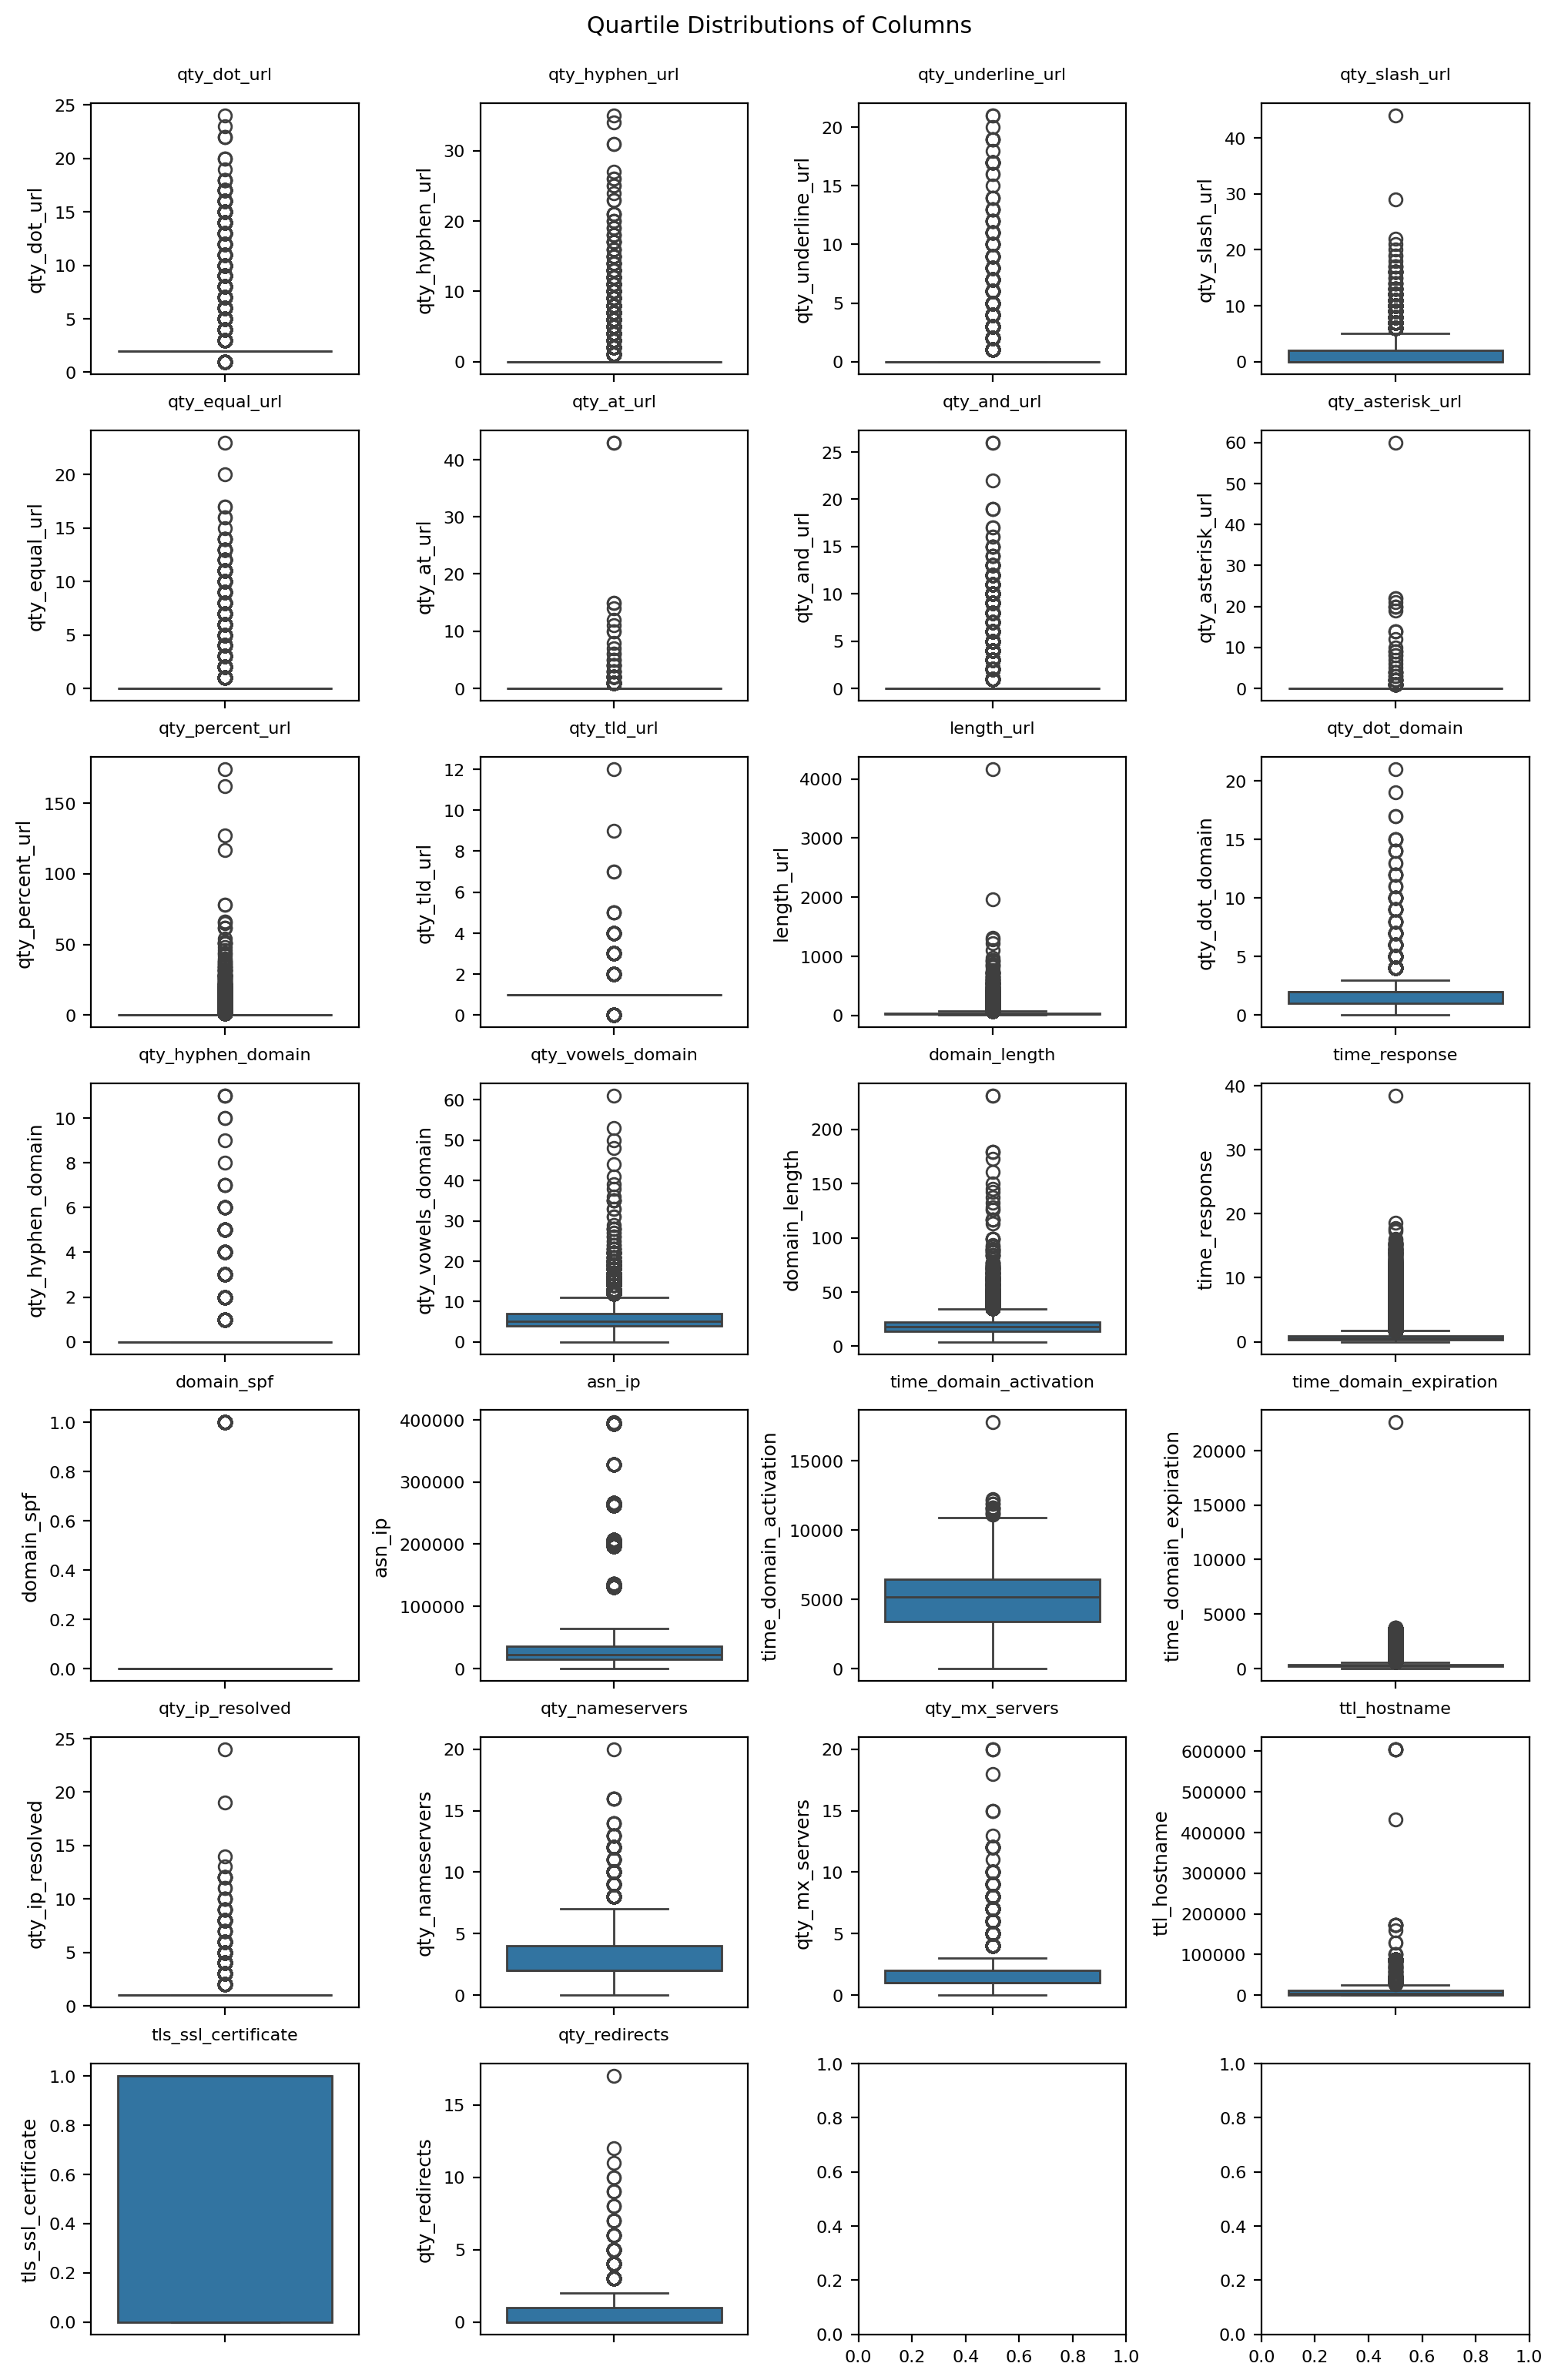

In [100]:
# investigating outliers using plots
fig,axes = plt.subplots(7,4, figsize=(10,15), constrained_layout=True)  # numbers of rows and columns of the subplots depend on the number of categ columns
axes = axes.flatten()
columns = df.columns.to_list() # updating the list of columns
del columns[-1]  # removing the target column
for col in columns :
    sns.boxplot(df[col], ax=axes[columns.index(col)])
    axes[columns.index(col)].set_title(col, fontsize=8)
plt.suptitle('Quartile Distributions of Columns', y=1.02)
plt.show()

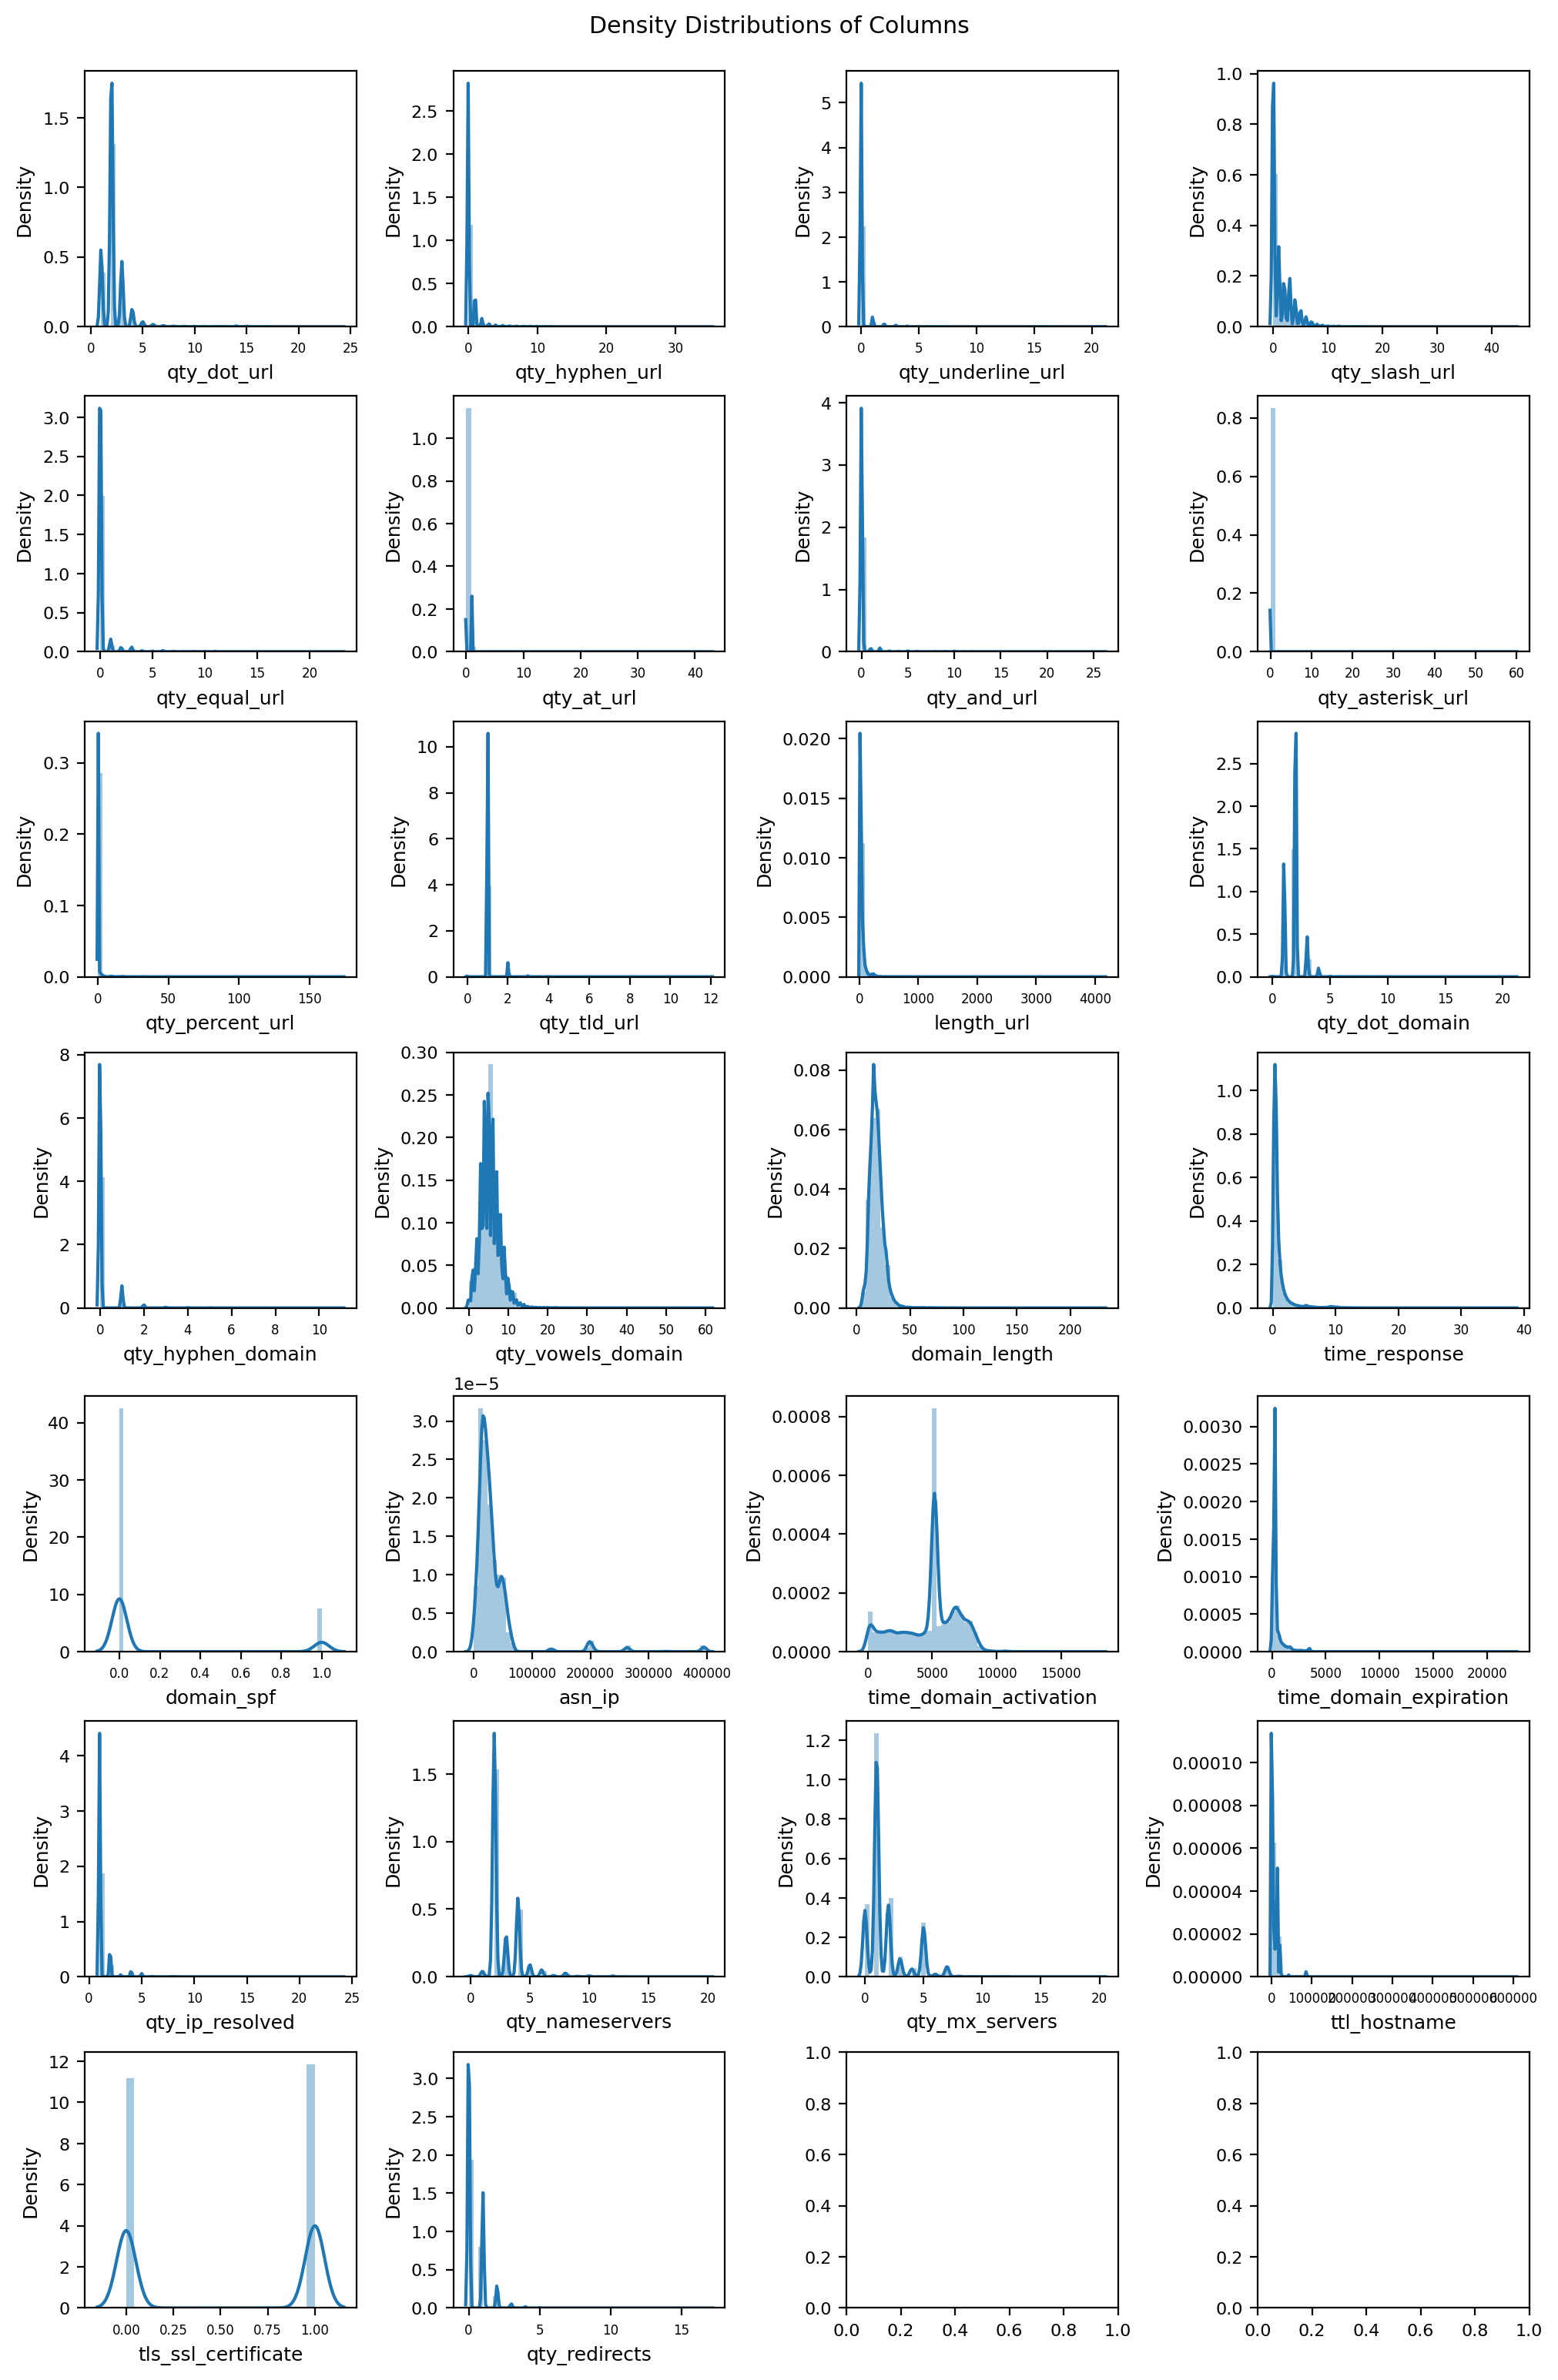

In [101]:
# another observation of outliers and data distribution using histogram and kde plots
fig,axes = plt.subplots(7,4, figsize=(10,15), constrained_layout=True)  # numbers of rows and columns of the subplots depend on the number of categ columns
axes = axes.flatten()
for col in columns :
    sns.distplot(df[col], ax=axes[columns.index(col)])
    axes[columns.index(col)].tick_params(axis="x", labelsize=6)
    #axes[columns.index(col)].set_title(col, fontsize=8)
plt.suptitle('Density Distributions of Columns', y=1.02)
plt.show()

In [102]:
# identify number and percentages of outliers for each column
col_outliers_list = []
lower_whisker_list = []
upper_whisker_list = []
for col in columns :
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    whisker_width = 1.5
    lower_whisker = q1 - whisker_width*iqr
    upper_whisker = q3 + whisker_width*iqr
    lower_whisker_list.append(lower_whisker)
    upper_whisker_list.append(upper_whisker)
    col_outliers = df[col][(df[col] < lower_whisker) | (df[col] > upper_whisker)]
    df_col_outliers = pd.DataFrame({"Number_Outliers":len(col_outliers),"%_Outliers":round(len(col_outliers)/df.shape[0]*100,1)}, index=[col])
    col_outliers_list.append(df_col_outliers)
df_outliers = pd.concat(col_outliers_list, axis=0)  # appending dataframes row-wise
df_outliers.sort_values(by='Number_Outliers', ascending=False, inplace=True)
df_outliers[df_outliers['Number_Outliers'] > 0]

,Number_Outliers,%_Outliers
qty_dot_url,34482,39.5
qty_hyphen_url,15384,17.6
time_domain_expiration,14201,16.3
qty_mx_servers,13781,15.8
domain_spf,13087,15.0
qty_ip_resolved,12361,14.2
time_response,8626,9.9
length_url,7983,9.2
qty_hyphen_domain,7981,9.2
qty_equal_url,7207,8.3


In [103]:
total_number_outliers = df_outliers['Number_Outliers'].sum()
total_number_values = df.count().sum()
print('Total number of outliers: ', total_number_outliers)
print('% of outliers of entire dataset: ', round(total_number_outliers/total_number_values*100, 1),'%')

Total number of outliers:  166373
% of outliers of entire dataset:  7.1 %


There is a significant amount of outliers. Instead of deleting or handling them, we use tree based algorithms which are insensitive to outliers

#### 3.6 Feature Correlation Analysis

In [104]:
# investigating Pearson's correlations of numerical columns against the target column
corr_matrix_target = abs(df.corr()['class']).sort_values(ascending=False)
round(corr_matrix_target,2)

class                     1.00
qty_slash_url             0.70
time_domain_activation    0.47
length_url                0.45
qty_dot_domain            0.27
qty_equal_url             0.26
qty_tld_url               0.21
qty_hyphen_url            0.20
qty_and_url               0.19
qty_underline_url         0.19
qty_dot_url               0.17
time_domain_expiration    0.15
qty_hyphen_domain         0.12
domain_spf                0.11
qty_vowels_domain         0.11
qty_at_url                0.11
qty_redirects             0.11
qty_mx_servers            0.09
asn_ip                    0.08
qty_ip_resolved           0.08
qty_nameservers           0.06
tls_ssl_certificate       0.05
qty_percent_url           0.02
qty_asterisk_url          0.02
ttl_hostname              0.02
time_response             0.02
domain_length             0.01
Name: class, dtype: float64

In [105]:
# # investigating correlations between columns using a heatmap of correlation matrix
# fig, ax = plt.subplots(figsize=(32, 32))
# corr_matrix = df.corr()
# mask = np.triu(corr_matrix)  # remove diagonal values which are always 1 and the upper triangle which is a duplicate of the lower one
# sns.heatmap(corr_matrix, annot=True, annot_kws={"fontsize":14}, fmt='.2f', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=mask, ax=ax) # annot=show numbers, fmt='.1f'= show 1 number of decimal places
# ax.set_title("Pearson Correlation Heatmap")
# # ax.xaxis.label.set_size(20)     # change xlabel size
# # ax.yaxis.label.set_size(20)     # change ylabel size
# ax.title.set_size(22)           # change subplot title size
# ax.tick_params(axis='x', labelsize=15)
# ax.tick_params(axis='y', labelsize=15)
# plt.show()

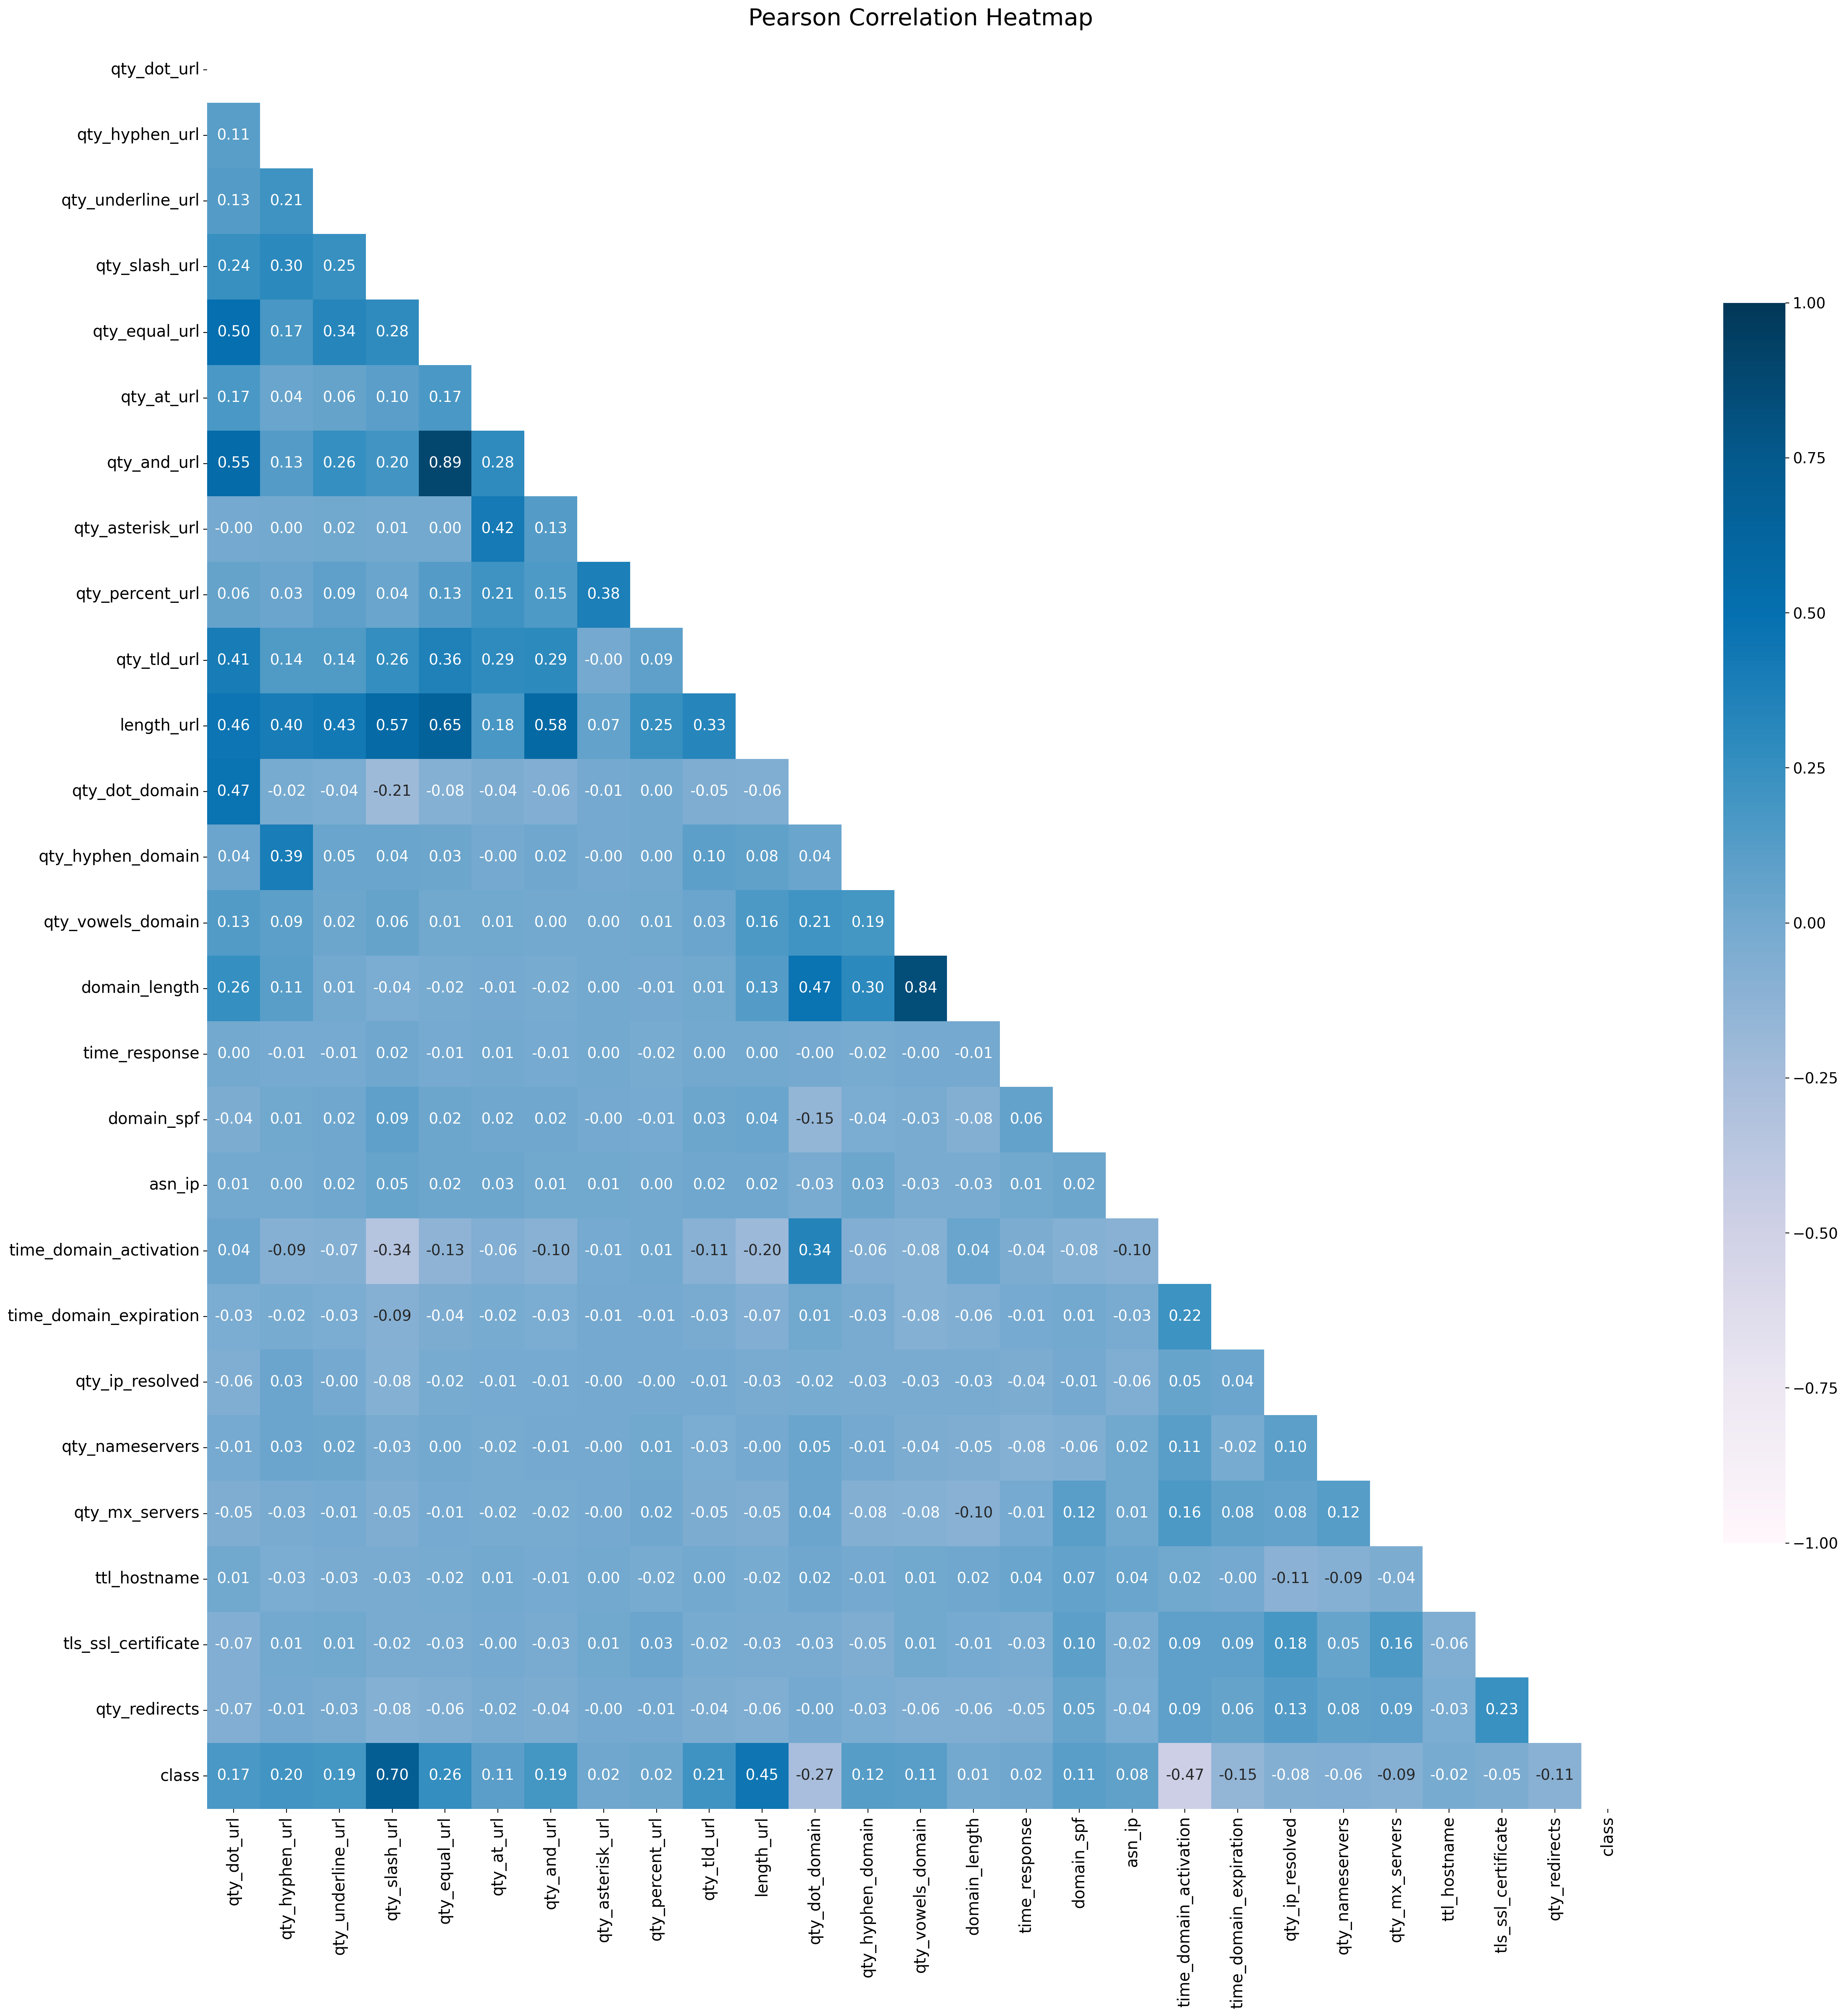

In [106]:
# investigating correlations between columns using heatmap of correlation matrix
fig, ax = plt.subplots(figsize=(30, 30))
corr_matrix = df.corr()
mask = np.triu(corr_matrix)  # remove diagonal values which are always 1 and the upper triangle which is a duplicate of the lower one
sns.heatmap(corr_matrix, annot=True, annot_kws={"fontsize":14}, cbar_kws={"shrink": 0.7}, fmt='.2f', vmin=-1, vmax=1, center= 0,
            cmap= 'PuBu', mask=mask, ax=ax) # annot=show numbers, fmt='.1f'= show 1 number of decimal places
ax.set_title("Pearson Correlation Heatmap")
# ax.xaxis.label.set_size(20)     # change xlabel size
# ax.yaxis.label.set_size(20)     # change ylabel size
ax.title.set_size(22)           # change subplot title size
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

# change font size of color bar texts
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.show()

In [107]:
# # investigating correlations between columns using a heatmap of correlation matrix
# plt.figure(figsize=(32,32))
# corr_matrix = df.corr()
# mask = np.triu(corr_matrix)  # remove diagonal values which are always 1 and the upper triangle which is a duplicate of the lower one
# sns.heatmap(corr_matrix, annot=True, annot_kws={"fontsize":14}, fmt='.2f', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=mask) # annot=show numbers, fmt='.1f'= show 1 number of decimal places
# plt.title("Pearson Correlation Heatmap", fontsize=20)
# # plt.rcParams['axes.titlesize'] = 25
# # #plt.rcParams['axes.labelsize'] = 20
# # plt.rcParams['xtick.labelsize'] = 16
# # plt.rcParams['ytick.labelsize'] = 16
# plt.show()

In [108]:
# Randomly select N number of samples from each class such that the resulting data is equally distributed in terms of the classes
# df = df.groupby('class', group_keys=False).apply(lambda x: x.sample(n=5000, random_state=RANDOM_STATE))
# df['class'].value_counts()

In [109]:
# Randomly select N number of samples from each class such that the resulting data is equally distributed in terms of the classes
N = 30000
df_phishing = df[df['class'] == 1].sample(n=N, random_state=RANDOM_STATE)
df_legitimate = df[df['class'] == 0].sample(n=N, random_state=RANDOM_STATE)
df = pd.concat([df_phishing, df_legitimate])
df['class'].value_counts()

1    30000
0    30000
Name: class, dtype: int64

In [110]:
df.head(3)

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_equal_url,qty_at_url,qty_and_url,qty_asterisk_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_vowels_domain,domain_length,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,class
27098,1,1,0,3,0,0,0,0,0,1,35,1,0,6,15,0.268954,0.0,3223.0,5187.0,281.0,1.0,2,1,14392.0,0,0.0,1
6233,2,0,0,4,0,0,0,0,0,1,67,2,0,7,21,0.631013,0.0,33494.0,953.0,873.0,1.0,2,1,2814.0,0,0.0,1
63354,2,0,0,2,0,0,0,0,0,1,38,2,0,12,32,0.440669,1.0,20013.0,3323.0,328.0,1.0,2,1,10649.0,1,0.0,1


#### 3.7 Train and Target Data Splitting

In [111]:
df = shuffle(df)
X = df.drop(["class"], axis=1)
y = df["class"]
print('Number of features in training data before feature selection: ', len(X.columns.to_list()))

Number of features in training data before feature selection:  26


#### 3.8 Handling Imbalanced Data

In [112]:
# # performing undersampling
# undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=RANDOM_STATE)
# X_resampled, y_resampled = undersampler.fit_resample(X, y)  # X_resampled and y_resampled returned as numpy array

# # confirm if the two classes are balanced. We first convert numpy arrays to dataframe
# cols = X.columns.to_list()
# df_X_resampled = pd.DataFrame(X_resampled, columns=cols)
# df_y_resampled = pd.DataFrame(y_resampled, columns=['class'])
# df_resampled = pd.concat([df_X_resampled, df_y_resampled], axis=1)
# df_resampled['class'].value_counts()

In [113]:
df.shape

(60000, 27)

#### 3.9 Train and Test Data Splitting

In [114]:
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=RANDOM_STATE,
#                                                     shuffle=True)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE, shuffle=True)

#### 3.10 Data Scaling

In [116]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# convert the scaled data back to dataframe from numpy array so that we can filter the data with the best features
# during model evaluation
cols = X.columns.to_list()
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cols)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cols)

#### 3.11 Feature Selection

In [117]:
cv = StratifiedKFold(n_splits=2, random_state=RANDOM_STATE, shuffle=True)

##### 3.11.1 Wrapper Method (RFECV)

In [118]:
# feature selection using RFECV, a wrapper method with cross validation
time_start1 = time.time()
rfecv = RFECV(estimator=RandomForestClassifier(), min_features_to_select=3, cv=cv, scoring='accuracy')
rfecv.fit(X_train_scaled, y_train)
df_features = pd.DataFrame(columns=['feature', 'support', 'ranking'])
for i in range(X.shape[1]):
    row = {'feature': X.columns[i], 'support': rfecv.support_[i], 'ranking': rfecv.ranking_[i]}
    df_features = pd.concat([df_features, pd.DataFrame([row])], ignore_index=True)  # append a new row to an existing dataframe
df_features.sort_values(by='ranking')
df_features = df_features[df_features['support']==True]  # selected best features always give support value as True
best_features_rfe = df_features['feature'].to_list()  # get all features
print("Number of Best Features: ", len(best_features_rfe))
print()
print('Best Features:\n', best_features_rfe)
time_end1 = time.time()
execTime1 = time_end1 - time_start1
print()
print('Time:' , round(execTime1/60,2), ' Min')

Number of Best Features:  22

Best Features:
 ['qty_dot_url', 'qty_hyphen_url', 'qty_underline_url', 'qty_slash_url', 'qty_equal_url', 'qty_and_url', 'qty_tld_url', 'length_url', 'qty_dot_domain', 'qty_hyphen_domain', 'qty_vowels_domain', 'domain_length', 'time_response', 'asn_ip', 'time_domain_activation', 'time_domain_expiration', 'qty_ip_resolved', 'qty_nameservers', 'qty_mx_servers', 'ttl_hostname', 'tls_ssl_certificate', 'qty_redirects']

Time: 3.47  Min


##### 3.11.2 Genetic Algorithm

In [119]:
# # feature selection using genetic algorithm from Sklearn-genetic-opt package
# time_start1 = time.time()
# clf = RandomForestClassifier()
# ga_selector = GAFeatureSelectionCV(
#                 estimator=clf,
#                 cv=cv,
#                 scoring="accuracy",
#                 #population_size=3,
#                 #population_size=50,
#                 population_size=100,
#                 generations=10,
#                 #generations=50,
#                 n_jobs=-1,
#                 verbose=True,
#                 #keep_top_k=2,
#                 elitism=True,
#             )
# ga_selector.fit(X_train_scaled, y_train)
# features = ga_selector.support_
# best_features_ga = list(X_train.columns[features])
# print()
# print('Number of Best Features:', len(best_features_ga))
# print()
# print('List of Best Features:\n', best_features_ga)
# time_end1 = time.time()
# execTime1 = time_end1 - time_start1
# print()
# print('Time:' , round(execTime1/60,2), ' Min')

# 5. Model Evaluation and Optimization

In [120]:
X_train = X_train_scaled_df[best_features_rfe]
X_test = X_test_scaled_df[best_features_rfe]

In [121]:
def get_scores(model, X, y, cv) :
    accuracy_scores = np.round(cross_val_score(model, X, y, cv=cv, scoring='accuracy'), 3)
    precision_scores = np.round(cross_val_score(model, X, y, cv=cv, scoring=make_scorer(precision_score)), 3)
    recall_scores = np.round(cross_val_score(model, X, y, cv=cv, scoring=make_scorer(recall_score)), 3)
    f1_scores = np.round(cross_val_score(model, X, y, cv=cv, scoring=make_scorer(f1_score)), 3)
    roc_auc_scores = np.round(cross_val_score(model, X, y, cv=cv, scoring='roc_auc'), 3)
    return accuracy_scores, precision_scores, recall_scores, f1_scores, roc_auc_scores

In [122]:
def get_mean_scores(accuracy_scores, precision_scores, recall_scores, f1_scores, roc_auc_scores) :
    accuracy_mean = np.round(np.mean(accuracy_scores), 3)
    precision_mean = np.round(np.mean(precision_scores), 3)
    recall_mean = np.round(np.mean(recall_scores), 3)
    f1_mean = np.round(np.mean(f1_scores), 3)
    roc_auc_mean = np.round(np.mean(roc_auc_scores), 3)
    return accuracy_mean, precision_mean, recall_mean, f1_mean, roc_auc_mean

In [123]:
# Define the search space bounds for each algorithm
search_spaces = {
    'RandomForest': {
        'n_estimators': Integer(100, 400),
        'max_depth': Integer(2, 30),
        'min_samples_split': Integer(2, 10),
        # 'min_samples_leaf': Integer(2, 10),
        #'bootstrap': Categorical([False, True]),
        # 'criterion' : Categorical(['gini', 'entropy']),
        'max_features': Categorical(['auto', 'sqrt', 'log2'])
    },
    'GradientBoosting': {
        'n_estimators': Integer(100, 400),
        'learning_rate': Continuous(0.01, 0.2),
        'max_depth': Integer(2, 30),
        'min_samples_split': Integer(2, 10),
        # 'min_samples_leaf': Integer(2, 10),
        # 'subsample': Continuous(0.7, 1.0),
        # 'max_features': Categorical(['auto', 'sqrt', 'log2'])
    },
    # 'HistGradientBoosting': {
    #     'max_depth': Integer(2, 30),
    #     'min_samples_leaf': Integer(2, 10),
    #     'max_leaf_nodes': Integer(15, 80)
    # },
    'Bagging': {
        'n_estimators': Integer(100, 400),
        'max_samples': Continuous(0.5, 1.0),
        'bootstrap': Categorical([False, True]),
        #'bootstrap_features': Categorical([False, True])
    },
    'AdaBoost': {
        'n_estimators': Integer(100, 400),
        'learning_rate': Continuous(0.01, 0.2),
        'algorithm' : Categorical(['SAMME', 'SAMME.R'])
    },
    'LGBM': {
        'n_estimators': Integer(100, 400),
        'learning_rate': Continuous(0.01, 0.2),
        'max_depth': Integer(2, 30),
        'num_leaves': Integer(15, 80),
        # 'subsample': Continuous(0.7, 1.0),
        # 'colsample_bytree': Continuous(0.7, 1.0)
    },
    'XGBoost': {
        'n_estimators': Integer(100, 400),
        'learning_rate': Continuous(0.01, 0.2),
        'max_depth': Integer(2, 30),
        'num_leaves': Integer(15, 80),
        # 'min_child_weight': Integer(1, 5),
        # 'subsample': Continuous(0.7, 1.0),
        # 'colsample_bytree': Continuous(0.7, 1.0)
    },
    # 'CatBoost': {
    #     'iterations': Integer(50, 150),
    #     'learning_rate': Continuous(0.01, 0.2),
    #     'depth': Integer(3, 15),
    #     'l2_leaf_reg': Integer(1, 5),
    #     'subsample': Continuous(0.7, 1.0)
    # },
    # 'ExtraTrees': {
    #     'n_estimators': Integer(100, 400),
    #     'max_depth': Integer(2, 30),
    #     'min_samples_split': Integer(2, 10),
    #     'min_samples_leaf': Integer(2, 10),
    #     'bootstrap': Categorical([False, True]),
    #     # 'criterion': Categorical(['gini', 'entropy'])
    # }
}

# Defining a list of names of all algorithms
algorithm_names = list(search_spaces.keys())

# Defining dictionary to store the best models for each algorithm
best_models = []

# Defining results dictionaries for individual models
results_base_models_dict = {'Algorithm': [],
                'Accuracy': [], 'Accuracy Scores': [],
                'Precision': [], 'Precision Scores': [],
                'Recall': [], 'Recall Scores': [],
                'F1': [], 'F1 Scores': [],
                'ROC_AUC': [], 'ROC_AUC Scores': [],
                #'Best_Params': []
                }

# Lists to store ROC and precision-recall curve data
roc_data = []
pr_data = []

In [124]:
# Defining a function of to pick the right model given an algorithm's name
def get_default_model(algorithm_name):
    model = None
    if algorithm_name == 'RandomForest':
        model = RandomForestClassifier(random_state=RANDOM_STATE)
    elif algorithm_name == 'GradientBoosting':
        model = GradientBoostingClassifier(random_state=RANDOM_STATE)
    elif algorithm_name == 'HistGradientBoosting':
        model = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
    elif algorithm_name == 'Bagging':
        model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=RANDOM_STATE)
    elif algorithm_name == 'AdaBoost':
        model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), random_state=RANDOM_STATE)
    elif algorithm_name == 'LGBM':
        model = LGBMClassifier(random_state=RANDOM_STATE)
    elif algorithm_name == 'XGBoost':
        model = XGBClassifier(random_state=RANDOM_STATE)
    elif algorithm_name == 'CatBoost':
        model = CatBoostClassifier(silent=True, random_state=RANDOM_STATE)
    elif algorithm_name == 'ExtraTrees':
        model = ExtraTreesClassifier(random_state=RANDOM_STATE)
    else:
        raise ValueError("Invalid algorithm name")
    return model

In [ ]:
for algorithm_name in algorithm_names:
    time_start2 = time.time()
    search_space = search_spaces[algorithm_name]
    model = get_default_model(algorithm_name)

    # Use GeneticSearchCV for hyperparameter tuning
    genetic_search_base = GASearchCV(estimator=model,
                                   cv=cv,
                                   scoring='accuracy',
                                   #population_size=5,
                                   #population_size=50,
                                   population_size=100,
                                   #generations=2,
                                   generations=10,
                                   #generations=50,
                                   #tournament_size=2,
                                   tournament_size=3,
                                   elitism=True,
                                   crossover_probability=0.8,
                                   mutation_probability=0.1,
                                   param_grid=search_space,
                                   criteria='max',
                                   algorithm='eaMuPlusLambda',
                                   n_jobs=-1,
                                   verbose=True,
                                   keep_top_k=2
                                )
    genetic_search_base.fit(X_train, y_train)
    best_model = genetic_search_base.best_estimator_
    best_params = genetic_search_base.best_params_
    best_models.append((algorithm_name, best_model))

    # Evaluate on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    # Best model evaluation with cross-validation
    accuracy_scores, precision_scores, recall_scores, f1_scores, roc_auc_scores = get_scores(best_model, X_train, y_train, cv)
    accuracy, precision, recall, f1, roc_auc = get_mean_scores(accuracy_scores, precision_scores, recall_scores,\
                                                               f1_scores, roc_auc_scores)
    print()
    print(algorithm_name, ' -- ', 'Accuracy:', accuracy,' | Precision:', precision,' | Recall:', recall,' | F1:', f1,' | AUC:', roc_auc)
    print('Best params:', best_params)

    # Store results (mean and scores) in the dictionary
    results_base_models_dict['Algorithm'].append(algorithm_name)
    results_base_models_dict['Accuracy Scores'].append(accuracy_scores)
    results_base_models_dict['Accuracy'].append(accuracy)
    results_base_models_dict['Precision Scores'].append(precision_scores)
    results_base_models_dict['Precision'].append(precision)
    results_base_models_dict['Recall Scores'].append(recall_scores)
    results_base_models_dict['Recall'].append(recall)
    results_base_models_dict['F1 Scores'].append(f1_scores)
    results_base_models_dict['F1'].append(f1)
    results_base_models_dict['ROC_AUC Scores'].append(roc_auc_scores)
    results_base_models_dict['ROC_AUC'].append(roc_auc)

    # Saving Precision-Recall curve data as a list of tuples
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_data.append((algorithm_name, recall, precision, auc(recall, precision)))

    # Saving ROC curve data as a list of tuples
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_data.append((algorithm_name, fpr, tpr, auc(fpr, tpr)))

    # Plotting confusion matrix
    #cm = confusion_matrix(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    cm = np.round(cm, 3)
    plt.figure(figsize=(3, 3))
    class_labels = {0: "Legitimate", 1: "Phishing"}
    sns.heatmap(cm, annot=True, fmt='.2g', cbar=False, xticklabels=[class_labels[i] for i in range(len(class_labels))],
            yticklabels=[class_labels[i] for i in range(len(class_labels))])
    plt.title(f'Confusion Matrix of {algorithm_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('Confusion Matrix-{algorithm_name}.png', dpi=150)
    plt.show()
    time_end2 = time.time()
    execTime2 = time_end2 - time_start2
    print('Time:' , round(execTime2/3600, 2), 'Hrs')
    print()

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	100   	0.946061	0.016751   	0.960604   	0.907208   
1  	178   	0.957505	0.00607354 	0.960708   	0.928417   


In [ ]:
# Create a dataframe from the results dictionary
df_base_models_results = pd.DataFrame(results_base_models_dict)

In [ ]:
# Sort dataframe by accuracy in descending order
df_base_models_results = df_base_models_results.sort_values(by=['Accuracy', 'F1'], ascending=[False, False]).reset_index(drop=True)
# Filter a dataframe of mean results only
df_base_models_mean_results = df_base_models_results[['Algorithm','Accuracy','Precision','Recall','F1', 'ROC_AUC']]
# Filter a dataframe of scores only
df_base_models_scores_results = df_base_models_results[['Algorithm','Accuracy Scores','Precision Scores','Recall Scores','F1 Scores', 'ROC_AUC Scores']]

In [ ]:
df_base_models_mean_results

In [ ]:
df_base_models_scores_results

In [ ]:
# Creating a combined Precision-Recall curves in subplot 1 and ROC curves in subplot 2
fig, axs = plt.subplots(1, 2, figsize=(9, 4), constrained_layout=True)

# Precision-Recall Curves
pr_data.sort(key=lambda x: x[3], reverse=True)  # Sort by PR AUC in descending order
axs[0].set_xlabel('Recall')
axs[0].set_ylabel('Precision')
axs[0].set_title('Precision-Recall Curves of Best Models')
for name, recall, precision, auc_score in pr_data:
    #axs[0].plot(recall, precision, label=f'{name} (AUC = {auc_score:.2f})')
    sns.lineplot(x=recall, y=precision, label=f'{name} (AUC = {auc_score:.2f})', ax=axs[0], ci=None)
# Add legends
axs[0].legend(loc='lower left', prop={'size':7})

# ROC Curves
roc_data.sort(key=lambda x: x[3], reverse=True)  # Sort by ROC AUC in descending order
axs[1].plot([0, 1], [0, 1], color='navy', lw=1.0, linestyle='--')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curves of Best Models')
for name, fpr, tpr, auc_score in roc_data:
    if isinstance(name, list):    # check if name is a list (meaning it is a stacked model)
        name = 'Stacking Ensemble'
    #axs[1].plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')
    sns.lineplot(x=fpr, y=tpr, label=f'{name} (AUC = {auc_score:.2f})', ax=axs[1], ci=None)
# Add legends
axs[1].legend(loc='lower right', prop={'size':7})
plt.savefig('PR-ROC Curves-1.png', dpi=150)
plt.show()

In [ ]:
# Creating a box plot of accuracy, F1 scores, and ROC_AUC scores of all best models for comparison
fig, axes = plt.subplots(1, 5, figsize=(20, 6), constrained_layout=True)

score_types = ['Accuracy Scores', 'Precision Scores', 'Recall Scores', 'F1 Scores', 'ROC_AUC Scores']
labels = df_base_models_scores_results["Algorithm"].to_list()
for ax, score_type in zip(axes, score_types):
    ax.boxplot(df_base_models_scores_results[f'{score_type}'], labels=labels, showmeans=True)
    #ax.set_ylabel(score_type)
    ax.set_xlabel('Model')
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.tick_params(axis='both', labelsize=7.5)
    ax.grid(axis='both', linestyle='--', linewidth=0.2, color='grey')
    ax.set_title(f'{score_type}', fontsize=10)

plt.suptitle('Comparison of Scores of Best Models', fontsize=17)
plt.savefig('Boxplots-Scores-1.png', dpi=150)
plt.show()

In [ ]:
# Creating bar plots of comparison of mean results of all best models
# Specify colors for each metric
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange']
# Extract x-axis positions based on algorithm names
labels = df_base_models_mean_results["Algorithm"].to_list()

# Create subplots for each metric
fig, axs = plt.subplots(1, 5, figsize=(20, 6), sharex=True)
# Plot bars for each metric in separate subplots
metrics = ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]
for i, metric in enumerate(metrics):
    axs[i].bar(labels, df_base_models_mean_results[metric], color=colors[i], label=metric)
    axs[i].set_title(metric)
    axs[i].set_xticks(labels)
    axs[i].set_xticklabels(labels, rotation=45, ha='right')  # Rotate labels for readability
    axs[i].set_ylim(0.7, 1.0)
    axs[i].grid(axis='y', linestyle='--', linewidth=0.2, color='black')
plt.suptitle('Performance (Mean Scores) Comparison of Best Models', fontsize=17)
# Adjust overall plot layout
plt.xticks(rotation=45)  # Reset x-axis label rotation
plt.tight_layout()
plt.savefig('Barplots-Mean Scores-1.png', dpi=150)
plt.show()

In [ ]:
# Creating bar plots of comparison of mean results of all best models
plt.figure(figsize=(6.5, 4.5))
barWidth = 0.17
# Set position of bar on X axis
r1 = range(len(df_base_models_mean_results['Algorithm']))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
# Plot bars
plt.bar(r1, df_base_models_mean_results['Accuracy'], width=barWidth, label='Accuracy', color='red')
plt.bar(r2, df_base_models_mean_results['Precision'], width=barWidth, label='Precision', color='green')
plt.bar(r3, df_base_models_mean_results['Recall'], width=barWidth, label='Recall', color='blue')
plt.bar(r4, df_base_models_mean_results['F1'], width=barWidth, label='F1', color='purple')
plt.bar(r5, df_base_models_mean_results['ROC_AUC'], width=barWidth, label='ROC_AUC', color='darkblue')
# Add labels
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks([r + barWidth*2.0 for r in range(len(df_base_models_mean_results['Algorithm']))], df_base_models_mean_results['Algorithm'])
plt.xticks(rotation=45, horizontalalignment="right")
plt.ylim([0.6, 1.0])
plt.title('Performance (Mean Scores) Comparison of Best Models')
plt.legend(bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.grid(axis='y', linestyle='--', linewidth=0.2, color='black')
plt.savefig('Barplot-Mean Scores-Combined-1.png', dpi=150)
plt.show()

In [ ]:
# Select the top model as the meta-classifier for the stacking model
top_model_name = df_base_models_results['Algorithm'][0]
for model_name, best_model in best_models:
    if model_name == top_model_name:
        meta_classifier = best_model
print('Best Base Model: ', meta_classifier)

In [ ]:
def feature_shap_analysis(model_name, model, X, y, file):
    # analysis of feature impact on the prediction using SHAP values
    model = model.fit(X, y)
    explainer = shap.Explainer(model)
    shap_values = explainer(X)

    # beeswarm plot
#     shap.summary_plot(shap_interaction, X)
#     shap.plots.bar(shap_values)
    shap.plots.beeswarm(shap_values, max_display=len(X), show=False, order=shap_values.abs.max(0))   # order features by their mean absolute value
    #shap.plots.beeswarm(shap_values[:,:,1], max_display=len(X), show=False, order=shap_values.abs.max(0)) # order features by their magnitude of shap values
    plt.title("SHAP Values of Samples per Feature")
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    plt.gcf().set_size_inches(6,7)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=8)
    plt.savefig(file, dpi=150)
    plt.show()

In [ ]:
# plot beeswarm plot of shap values
saving_file = '{model_name} SHAP Plot Base Models.png'
feature_shap_analysis(top_model_name, meta_classifier, X_train, y_train, saving_file)

In [ ]:
# Select the top 3 tuned models for base classifiers in terms of accuracy
base_model_names = df_base_models_results['Algorithm'][0:3].to_list()
print('Top 3 Base Model Names as Base Classifiers:')
base_model_names

In [ ]:
# # Select the tuned models for base classifiers ranked by their accuracy rates
# base_model_names = df_base_models_results['Algorithm'].to_list()
# print('List of Base Classifiers:')
# base_model_names

In [ ]:
# Defining a dictionary to store the results of tuned stacking models
results_stacking_models_dict = {
                              'Algorithm': [],
                              'Accuracy': [], 'Accuracy Scores': [],
                              'Precision': [], 'Precision Scores': [],
                              'Recall': [], 'Recall Scores': [],
                              'F1': [], 'F1 Scores': [],
                              'ROC_AUC': [], 'ROC_AUC Scores': [],
                                }
# Defining lists of tuples of precision-recall curve data, roc auc curve data and confusion matrices of stacking models
pr_stacking_data = []
roc_stacking_data = []
confusion_matrix_stacking = []

In [ ]:
# Generate combinations of at least 2 top tuned models for forming base models for stacking classifiers
combinations_base_models = [c for i in range(len(base_model_names)) for c in itertools.combinations(base_model_names, i+2)]
print('Number of Base Model Combinations:', len(combinations_base_models))

In [ ]:
# Evaluate each combination and form a stacking model
for combination in combinations_base_models:
    base_models_subset = [(name, dict(best_models)[name]) for name in combination]

    # Stacking model
    stacking_model = StackingClassifier(estimators=base_models_subset, final_estimator=meta_classifier, cv=2)
    stacking_model.fit(X_train, y_train)

    stack_accuracy_scores, stack_precision_scores, stack_recall_scores, stack_f1_scores, stack_roc_auc_scores \
            = get_scores(stacking_model, X_train, y_train, cv)
    stack_accuracy, stack_precision, stack_recall, stack_f1, stack_roc_auc \
            = get_mean_scores(accuracy_scores, precision_scores, recall_scores, f1_scores, roc_auc_scores)

    # Evaluate on the test set
    y_pred = stacking_model.predict(X_test)
    y_prob = stacking_model.predict_proba(X_test)[:, 1]

    # Train the best stacking model
    best_models.append((combination, stacking_model))

    # Evaluate on the test set
    y_pred = stacking_model.predict(X_test)
    y_prob = stacking_model.predict_proba(X_test)[:, 1]

    # Store results (scores and mean scores) in the dictionary
    model_combo_names = [name for name, _ in base_models_subset]
    results_stacking_models_dict['Algorithm'].append(model_combo_names)
    results_stacking_models_dict['Accuracy Scores'].append(stack_accuracy_scores)
    results_stacking_models_dict['Accuracy'].append(stack_accuracy)
    results_stacking_models_dict['Precision Scores'].append(stack_precision_scores)
    results_stacking_models_dict['Precision'].append(stack_precision)
    results_stacking_models_dict['Recall Scores'].append(stack_recall_scores)
    results_stacking_models_dict['Recall'].append(stack_recall)
    results_stacking_models_dict['F1 Scores'].append(stack_f1_scores)
    results_stacking_models_dict['F1'].append(stack_f1)
    results_stacking_models_dict['ROC_AUC Scores'].append(stack_roc_auc_scores)
    results_stacking_models_dict['ROC_AUC'].append(stack_roc_auc)

    # Saving Precision-Recall Curve data as a list of tuples
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_stacking_data.append((model_combo_names, recall, precision, auc(recall, precision)))

    # Saving ROC Curve data as a list of tuples
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_stacking_data.append((model_combo_names, fpr, tpr, auc(fpr, tpr)))

    # saving tuples of confusion matrices of stacked models
    confusion_matrix_stacking.append((model_combo_names, confusion_matrix(y_test, y_pred)))

In [ ]:
# Create a dataframe from the results dictionary for tuned stacked models
df_results_stacking_models = pd.DataFrame(results_stacking_models_dict)
df_results_stacking_models.head(3)

In [ ]:
# Sort dataframe by accuracy in descending order
df_results_stacking_models = df_results_stacking_models.sort_values(by=['Accuracy', 'F1'], ascending=[False, False]).reset_index(drop=True)
# Filter a dataframe of mean results only
df_results_stacking_mean_models = df_results_stacking_models[['Algorithm','Accuracy','Precision','Recall','F1', 'ROC_AUC']]
# Filter a dataframe of scores only
df_results_stacking_scores_models = df_results_stacking_models[['Algorithm','Accuracy Scores','Precision Scores','Recall Scores','F1 Scores', 'ROC_AUC Scores']]

In [ ]:
# Picking the best performing stacking model
df_top_stacking_mean_model = df_results_stacking_mean_models.head(1)
df_top_stacking_scores_model = df_results_stacking_scores_models.head(1)
# Display mean results of the best stacking model
df_top_stacking_mean_model

In [ ]:
# Identifying the best stacking combination
top_stacking_combination_name = df_top_stacking_mean_model['Algorithm'][0]
print('Best stacking combination: ', top_stacking_combination_name)

In [ ]:
# Finding roc and pr data of the top stacked model and append to those of base models
for name, rec, prec, pr_auc in pr_stacking_data:
    if name == top_stacking_combination_name:
        pr_data.append((name, rec, prec, pr_auc))

for name, fpr, tpr, roc_auc in roc_stacking_data:
    if name == top_stacking_combination_name:
        roc_data.append((name, fpr, tpr, roc_auc))

In [ ]:
import matplotlib.pyplot as plt
# ploting confusion matrix of the best stacking model
for name, confusion_matrix in confusion_matrix_stacking:
    if name == top_stacking_combination_name:
        cm = confusion_matrix
        Algorithm = 'Stacking Ensemble'
plt.figure(figsize=(3, 3))
class_labels = {0: "Legitimate", 1: "Phishing"}
sns.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=[class_labels[i] for i in range(len(class_labels))],
            yticklabels=[class_labels[i] for i in range(len(class_labels))])
plt.title(f'Confusion Matrix of {Algorithm}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('Confusion Matrix-Stacking Ensemble.png', dpi=150)
plt.show()

In [ ]:
# Merge the two dataframes i.e base models and the best stacking model
df_mean_results = pd.concat([df_base_models_mean_results, df_top_stacking_mean_model])
df_scores_results = pd.concat([df_base_models_scores_results, df_top_stacking_scores_model])

In [ ]:
# Change name of the stacking model
df_mean_results['Algorithm'].iloc[-1] = 'Stacking Ensemble'
df_scores_results['Algorithm'].iloc[-1] = 'Stacking Ensemble'

In [ ]:
df_mean_results

In [ ]:
df_scores_results

In [ ]:
# Creating a combined Precision-Recall curves in subplot 1 and ROC curves in subplot 2
fig, axs = plt.subplots(1, 2, figsize=(9, 4), constrained_layout=True)

# Precision-Recall Curves
pr_data.sort(key=lambda x: x[3], reverse=True)  # Sort by PR AUC in descending order
axs[0].set_xlabel('Recall')
axs[0].set_ylabel('Precision')
axs[0].set_title('Precision-Recall Curves of Best Models')
for name, recall, precision, auc_score in pr_data:
    if isinstance(name, list):    # check if name is a list (meaning it is a stacked model)
        name = 'Stacking Ensemble'
    #axs[0].plot(recall, precision, label=f'{name} (AUC = {auc_score:.2f})')
    sns.lineplot(x=recall, y=precision, label=f'{name} (AUC = {auc_score:.2f})', ax=axs[0], ci=None)
# Add legends
axs[0].legend(loc='lower left', prop={'size':7})

# ROC Curves
roc_data.sort(key=lambda x: x[3], reverse=True)  # Sort by ROC AUC in descending order
axs[1].plot([0, 1], [0, 1], color='navy', lw=1.0, linestyle='--')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curves of Best Models')
for name, fpr, tpr, auc_score in roc_data:
    if isinstance(name, list):    # check if name is a list (meaning it is a stacked model)
        name = 'Stacking Ensemble'
    #axs[1].plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')
    sns.lineplot(x=fpr, y=tpr, label=f'{name} (AUC = {auc_score:.2f})', ax=axs[1], ci=None)
# Add legends
axs[1].legend(loc='lower right', prop={'size':7})
plt.savefig('PR-ROC Curves-2.png', dpi=150)
plt.show()

In [ ]:
# Creating a box plot of accuracy, F1 scores, and ROC_AUC scores of all best models for comparison
fig, axes = plt.subplots(1, 5, figsize=(20, 6), constrained_layout=True)

score_types = ['Accuracy Scores', 'Precision Scores', 'Recall Scores', 'F1 Scores', 'ROC_AUC Scores']
labels = df_mean_results["Algorithm"].to_list()
for ax, score_type in zip(axes, score_types):
    ax.boxplot(df_scores_results[f'{score_type}'], labels=labels, showmeans=True)
    #ax.set_ylabel(score_type)
    ax.set_xlabel('Model')
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.tick_params(axis='both', labelsize=7.5)
    ax.grid(axis='both', linestyle='--', linewidth=0.2, color='grey')
    ax.set_title(f'{score_type}', fontsize=10)

plt.suptitle('Comparison of Scores of Best Models', fontsize=17)
plt.savefig('Boxplots-Scores-2.png', dpi=150)
plt.show()

In [ ]:
# Creating bar plots of comparison of mean results of all best models
# Specify colors for each metric
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange']
# Extract x-axis positions based on algorithm names
labels = df_mean_results["Algorithm"].to_list()

# Create subplots for each metric
fig, axs = plt.subplots(1, 5, figsize=(20, 6), sharex=True)
# Plot bars for each metric in separate subplots
metrics = ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]
for i, metric in enumerate(metrics):
    axs[i].bar(labels, df_mean_results[metric], color=colors[i], label=metric)
    axs[i].set_title(metric)
    axs[i].set_xticks(labels)
    axs[i].set_xticklabels(labels, rotation=45, ha='right')  # Rotate labels for readability
    axs[i].set_ylim(0.7, 1.0)
    axs[i].grid(axis='y', linestyle='--', linewidth=0.2, color='black')
plt.suptitle('Performance (Mean Scores) Comparison of Best Models', fontsize=17)
# Adjust overall plot layout
plt.xticks(rotation=45)  # Reset x-axis label rotation
plt.tight_layout()
plt.savefig('Barplots-Mean Scores-2.png', dpi=150)
plt.show()

In [ ]:
# Creating bar plots of comparison of mean results of all best models
plt.figure(figsize=(6.5, 4.5))
barWidth = 0.17
# Set position of bar on X axis
r1 = range(len(df_mean_results['Algorithm']))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
# Plot bars
plt.bar(r1, df_mean_results['Accuracy'], width=barWidth, label='Accuracy', color='red')
plt.bar(r2, df_mean_results['Precision'], width=barWidth, label='Precision', color='green')
plt.bar(r3, df_mean_results['Recall'], width=barWidth, label='Recall', color='blue')
plt.bar(r4, df_mean_results['F1'], width=barWidth, label='F1', color='purple')
plt.bar(r5, df_mean_results['ROC_AUC'], width=barWidth, label='ROC_AUC', color='darkblue')
# Add labels
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks([r + barWidth*2.0 for r in range(len(df_mean_results['Algorithm']))], df_mean_results['Algorithm'])
plt.xticks(rotation=45, horizontalalignment="right")
plt.ylim([0.6, 1.0])
plt.title('Performance (Mean Scores) Comparison of Best Models')
plt.legend(bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.grid(axis='y', linestyle='--', linewidth=0.2, color='black')
plt.savefig('Barplot-Mean Scores-Combined-2.png', dpi=150)
plt.show()

In [ ]:
time_end = time.time()
execTime = time_end - time_start
print('Time:' , round(execTime/3600,2), 'Hrs')

In [ ]:
# get name of the best model
top_model_name = df_mean_results['Algorithm'].head(1)[0]
top_model_name

In [ ]:
for algorithm_name, model in best_models:
    if algorithm_name == top_model_name:
        name = top_model_name
        top_model = model
if isinstance(name, list):
    name = 'Stacking Ensemble'
# plot beeswarm plot of shap values
saving_file = '{model_name} SHAP Plot Base+Meta Models.png'
feature_shap_analysis(name, top_model, X_train, y_train, saving_file)